In [ ]:
!nvidia-smi

Wed Aug 23 04:33:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.utils import shuffle as util_shuffle
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm


In [ ]:
# Dataset iterator
def make_dataset(rng=None, size=200):
    if rng is None:
      rng = np.random.RandomState()

    radial_std = 0.3
    tangential_std = 0.1
    num_classes = 5
    num_per_class = size // 5
    rate = 0.25
    rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

    features = rng.randn(num_classes*num_per_class, 2) \
        * np.array([radial_std, tangential_std])
    features[:, 0] += 1.
    labels = np.repeat(np.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * np.exp(features[:, 0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))
    condition = labels
    data = 2 * np.einsum("ti,tij->tj", features, rotations)
    data, condition = util_shuffle(data, condition)

    return data, condition

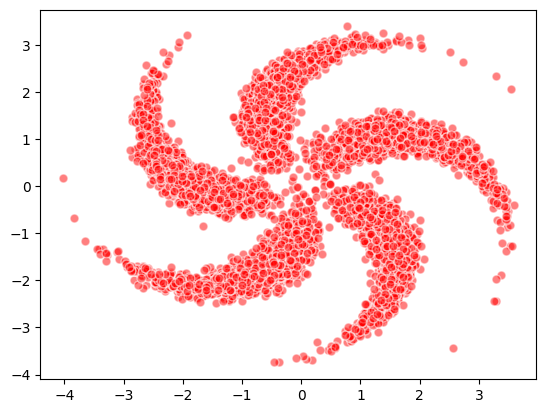

In [ ]:
data, _ = make_dataset(size=10000)
dataset = torch.tensor(data).float()

plt.clf()
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='red', edgecolor='white', s=40)
plt.show()

In [ ]:
def beta_schedule(beta1, beta2, T, schedule='sigmoid'):
    if schedule == 'linear':
        betas = torch.linspace(beta1, beta2, T)
    elif schedule == "quad":
        betas = torch.linspace(beta1 ** 0.5, beta2 ** 0.5, T) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, T)
        betas = torch.sigmoid(betas) * (beta2 - beta1) + beta1
    return betas

def ddpm_schedules(beta1, beta2, T, schedule='sigmoid'):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = beta_schedule(beta1, beta2, T, schedule)
    # beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "beta_t": beta_t,    # \beta_t
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }



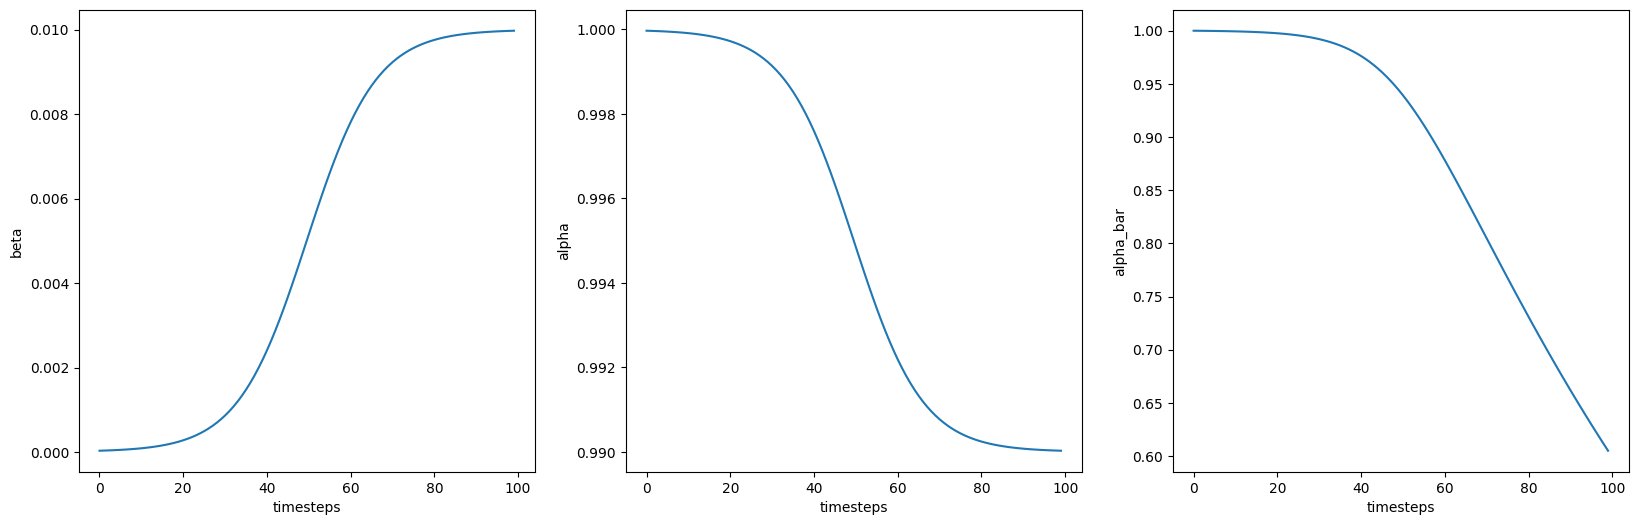

In [ ]:
# ddpm scheduling check

import matplotlib.pyplot as plt

n_T = 100

ddpm_scheduling_dict = ddpm_schedules(1e-5, 1e-2, n_T)

beta = ddpm_scheduling_dict['beta_t']
alpha = ddpm_scheduling_dict['alpha_t']
alpha_bar = ddpm_scheduling_dict['alphabar_t']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

axes[0].plot(np.arange(len(beta)), beta)
axes[0].set_xlabel('timesteps')
axes[0].set_ylabel('beta')

axes[1].plot(np.arange(len(alpha)), alpha)
axes[1].set_xlabel('timesteps')
axes[1].set_ylabel('alpha')

axes[2].plot(np.arange(len(alpha_bar)), alpha_bar)
axes[2].set_xlabel('timesteps')
axes[2].set_ylabel('alpha_bar')

plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

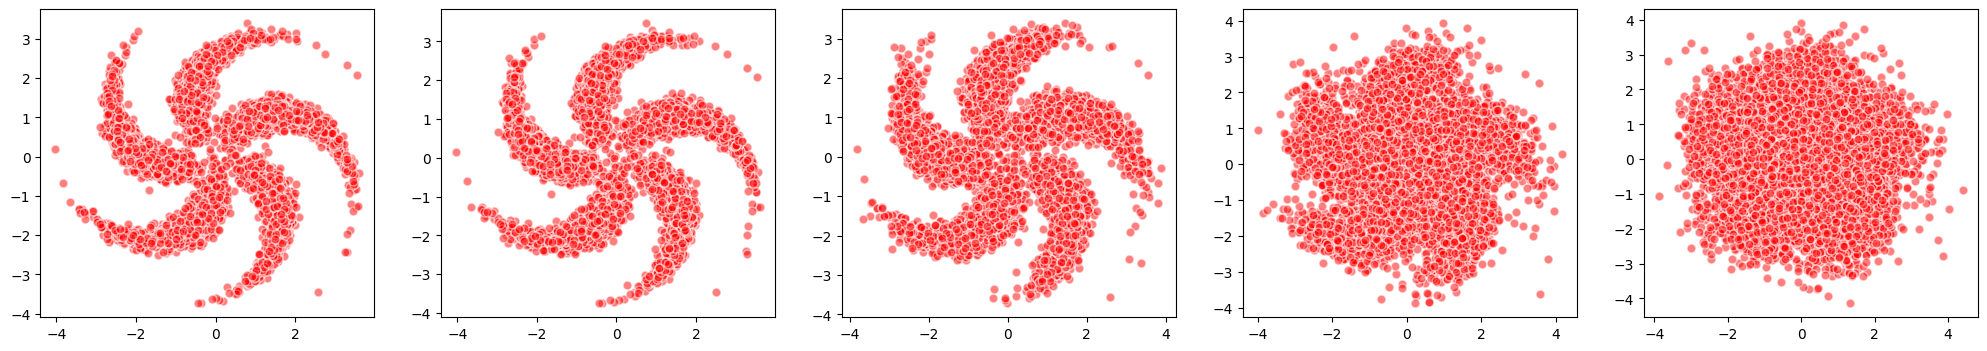

<Figure size 640x480 with 0 Axes>

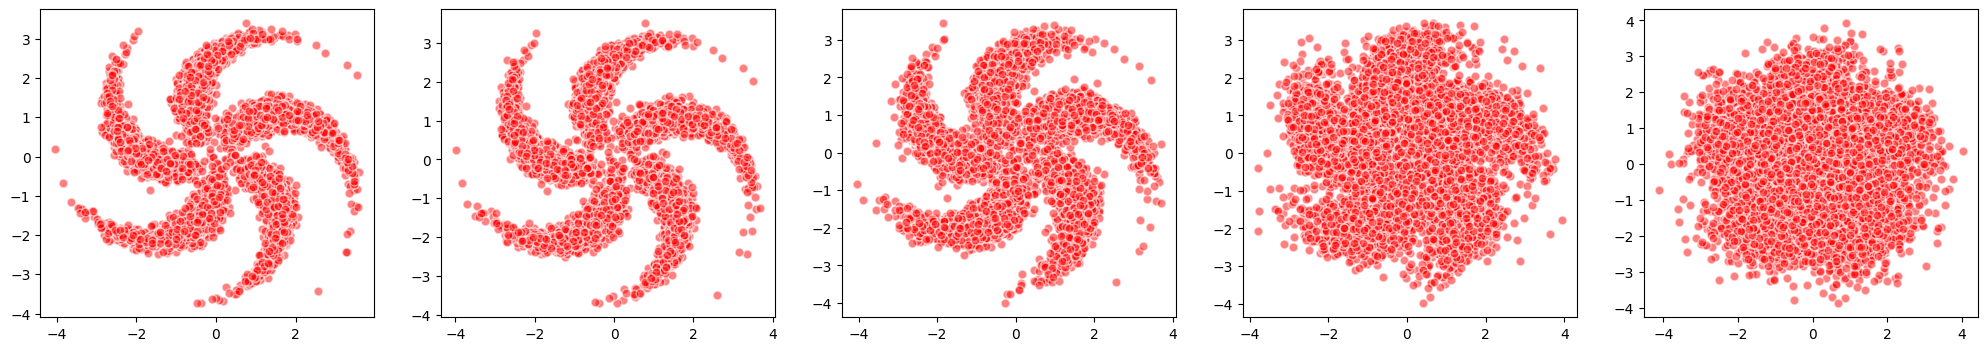

In [ ]:
sample_batch = dataset

forward_list = []
forward_list2 = []

x = sample_batch
for t in range(n_T):
    x = torch.sqrt(1 - ddpm_scheduling_dict['beta_t'][t, None]) * x + torch.sqrt(ddpm_scheduling_dict['beta_t'][t, None]) * torch.randn_like(x)
    if t % (n_T//5) == 0:
        forward_list.append(x.detach().cpu())

for t in range(n_T):
    if t % (n_T//5) == 0:
        x = ddpm_scheduling_dict['sqrtab'][t, None] * sample_batch + ddpm_scheduling_dict['sqrtmab'][t, None] * torch.randn_like(sample_batch)
        forward_list2.append(x.detach().cpu())

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 4))
for i in range(5):
  axes[i].scatter(forward_list[i][:, 0].cpu(), forward_list[i][:, 1].cpu(), alpha=0.5, color='red', edgecolor='white', s=40)
plt.show()
plt.close()

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 4))
for i in range(5):
  axes[i].scatter(forward_list2[i][:, 0].cpu(), forward_list2[i][:, 1].cpu(), alpha=0.5, color='red', edgecolor='white', s=40)
plt.show()
plt.close()

In [ ]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out

class TimeConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(TimeConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)

    def forward(self, x, t):
        x = F.softplus(self.lin1(x, t))
        x = F.softplus(self.lin2(x, t))
        x = F.softplus(self.lin3(x, t))
        return self.lin4(x)

In [ ]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.loss_mse = nn.MSELoss()

    def forward(self, x):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(0, self.n_T, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None] * x
            + self.sqrtmab[_ts, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, _ts))

    def sample(self, n_sample, size, device):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        x_i_store = [] # keep track of generated steps in case want to plot something
        print()
        for i in range(self.n_T-1, -1, -1):
            t_is = torch.tensor([i]).to(device)
            t_is = t_is.repeat(n_sample,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, t_is)
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [ ]:
device='cuda:0'
n_epoch = 1000                             # total training epoch
batch_size = 256                          # number of data in each iteration
n_T = 200                                 # total timesteps of diffusion process
lrate = 1e-3                              # learning rate
save_dir = './toy_data_results/'
os.makedirs(save_dir, exist_ok=True)

ddpm = DDPM(nn_model=TimeConditionalModel(n_steps=n_T), betas=(1e-5, 1e-2), n_T=n_T, device=device)
ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)


In [ ]:
plt.ioff()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    ddpm.train()

    permutation = torch.randperm(dataset.size()[0])
    pbar = tqdm(list(range(0, dataset.size()[0], batch_size)))
    loss_ema = None
    for i in pbar:
        indices = permutation[i:i+batch_size]
        x = dataset[indices].to(device)
        loss = ddpm(x)
        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ddpm.parameters(), 1.)
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

    # for eval, save an image of currently generated samples (top rows)
    # followed by real images (bottom rows)
    ddpm.eval()
    if ep%100==0 or ep == int(n_epoch-1):
        with torch.no_grad():
            x_gen, x_gen_store = ddpm.sample(10000, (2,), device)
            plt.clf()
            plt.figure(figsize=(16, 12))
            plt.scatter(x_gen[:, 0].cpu(), x_gen[:, 1].cpu(), alpha=0.5, color='red', edgecolor='white', s=40)
            plt.savefig(save_dir + f"samples_ep{ep}.png")
            print('visualize samples at ' + save_dir + f"samples_ep{ep}.png")

            # create gif of images evolving over time, based on x_gen_store
            fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True,sharey=True,figsize=(8,8))
            def animate_diff(i, x_gen_store):
                print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                plots = []
                axs.clear()
                plots.append(axs.scatter(x_gen_store[i, :, 0], x_gen_store[i, :, 1], alpha=0.5, color='red', edgecolor='white', s=40))
                return plots
            # fig, axs = plt.subplots(sharex=True,sharey=True,figsize=(8,8))
            ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])
            ani.save(save_dir + f"gif_ep{ep}.gif", dpi=100, writer=PillowWriter(fps=5))
            print('saved image at ' + save_dir + f"gif_ep{ep}.gif")
            plt.close('all')

    # optionally save model
    if ep == int(n_epoch-1):
        torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


loss: 1.0320: 100%|██████████| 40/40 [00:01<00:00, 36.80it/s]



visualize samples at ./toy_data_results/samples_ep0.png
saved image at ./toy_data_results/gif_ep0.gif
epoch 1


loss: 0.9460: 100%|██████████| 40/40 [00:00<00:00, 176.92it/s]


epoch 2


loss: 0.9243: 100%|██████████| 40/40 [00:00<00:00, 176.50it/s]


epoch 3


loss: 0.9055: 100%|██████████| 40/40 [00:00<00:00, 187.06it/s]


epoch 4


loss: 0.9002: 100%|██████████| 40/40 [00:00<00:00, 180.13it/s]


epoch 5


loss: 0.9100: 100%|██████████| 40/40 [00:00<00:00, 170.74it/s]


epoch 6


loss: 0.8824: 100%|██████████| 40/40 [00:00<00:00, 177.43it/s]


epoch 7


loss: 0.9167: 100%|██████████| 40/40 [00:00<00:00, 175.92it/s]


epoch 8


loss: 0.9224: 100%|██████████| 40/40 [00:00<00:00, 188.48it/s]


epoch 9


loss: 0.9037: 100%|██████████| 40/40 [00:00<00:00, 175.76it/s]


epoch 10


loss: 0.8762: 100%|██████████| 40/40 [00:00<00:00, 176.46it/s]


epoch 11


loss: 0.8845: 100%|██████████| 40/40 [00:00<00:00, 179.08it/s]


epoch 12


loss: 0.8869: 100%|██████████| 40/40 [00:00<00:00, 175.35it/s]


epoch 13


loss: 0.8911: 100%|██████████| 40/40 [00:00<00:00, 189.85it/s]


epoch 14


loss: 0.8757: 100%|██████████| 40/40 [00:00<00:00, 192.72it/s]


epoch 15


loss: 0.8840: 100%|██████████| 40/40 [00:00<00:00, 177.09it/s]


epoch 16


loss: 0.8986: 100%|██████████| 40/40 [00:00<00:00, 151.89it/s]


epoch 17


loss: 0.9036: 100%|██████████| 40/40 [00:00<00:00, 171.60it/s]


epoch 18


loss: 0.8743: 100%|██████████| 40/40 [00:00<00:00, 161.02it/s]


epoch 19


loss: 0.8772: 100%|██████████| 40/40 [00:00<00:00, 189.28it/s]


epoch 20


loss: 0.8777: 100%|██████████| 40/40 [00:00<00:00, 180.57it/s]


epoch 21


loss: 0.8967: 100%|██████████| 40/40 [00:00<00:00, 182.72it/s]


epoch 22


loss: 0.8799: 100%|██████████| 40/40 [00:00<00:00, 185.78it/s]


epoch 23


loss: 0.8762: 100%|██████████| 40/40 [00:00<00:00, 181.84it/s]


epoch 24


loss: 0.8714: 100%|██████████| 40/40 [00:00<00:00, 174.45it/s]


epoch 25


loss: 0.8644: 100%|██████████| 40/40 [00:00<00:00, 158.21it/s]


epoch 26


loss: 0.9120: 100%|██████████| 40/40 [00:00<00:00, 149.53it/s]


epoch 27


loss: 0.8994: 100%|██████████| 40/40 [00:00<00:00, 158.27it/s]


epoch 28


loss: 0.9029: 100%|██████████| 40/40 [00:00<00:00, 157.82it/s]


epoch 29


loss: 0.8666: 100%|██████████| 40/40 [00:00<00:00, 160.92it/s]


epoch 30


loss: 0.8698: 100%|██████████| 40/40 [00:00<00:00, 163.16it/s]


epoch 31


loss: 0.8822: 100%|██████████| 40/40 [00:00<00:00, 158.42it/s]


epoch 32


loss: 0.8948: 100%|██████████| 40/40 [00:00<00:00, 168.50it/s]


epoch 33


loss: 0.8990: 100%|██████████| 40/40 [00:00<00:00, 170.43it/s]


epoch 34


loss: 0.8616: 100%|██████████| 40/40 [00:00<00:00, 175.48it/s]


epoch 35


loss: 0.8578: 100%|██████████| 40/40 [00:00<00:00, 195.87it/s]


epoch 36


loss: 0.8900: 100%|██████████| 40/40 [00:00<00:00, 179.57it/s]


epoch 37


loss: 0.8532: 100%|██████████| 40/40 [00:00<00:00, 174.53it/s]


epoch 38


loss: 0.8735: 100%|██████████| 40/40 [00:00<00:00, 204.73it/s]


epoch 39


loss: 0.8656: 100%|██████████| 40/40 [00:00<00:00, 203.07it/s]


epoch 40


loss: 0.8830: 100%|██████████| 40/40 [00:00<00:00, 185.52it/s]


epoch 41


loss: 0.8506: 100%|██████████| 40/40 [00:00<00:00, 197.78it/s]


epoch 42


loss: 0.8818: 100%|██████████| 40/40 [00:00<00:00, 189.40it/s]


epoch 43


loss: 0.8396: 100%|██████████| 40/40 [00:00<00:00, 175.90it/s]


epoch 44


loss: 0.8773: 100%|██████████| 40/40 [00:00<00:00, 179.44it/s]


epoch 45


loss: 0.8469: 100%|██████████| 40/40 [00:00<00:00, 192.25it/s]


epoch 46


loss: 0.8460: 100%|██████████| 40/40 [00:00<00:00, 190.28it/s]


epoch 47


loss: 0.8583: 100%|██████████| 40/40 [00:00<00:00, 194.67it/s]


epoch 48


loss: 0.8633: 100%|██████████| 40/40 [00:00<00:00, 201.96it/s]


epoch 49


loss: 0.8487: 100%|██████████| 40/40 [00:00<00:00, 184.27it/s]


epoch 50


loss: 0.8479: 100%|██████████| 40/40 [00:00<00:00, 189.37it/s]


epoch 51


loss: 0.8889: 100%|██████████| 40/40 [00:00<00:00, 199.70it/s]


epoch 52


loss: 0.8558: 100%|██████████| 40/40 [00:00<00:00, 191.10it/s]


epoch 53


loss: 0.8272: 100%|██████████| 40/40 [00:00<00:00, 179.69it/s]


epoch 54


loss: 0.8809: 100%|██████████| 40/40 [00:00<00:00, 192.77it/s]


epoch 55


loss: 0.8661: 100%|██████████| 40/40 [00:00<00:00, 177.67it/s]


epoch 56


loss: 0.8463: 100%|██████████| 40/40 [00:00<00:00, 191.64it/s]


epoch 57


loss: 0.8365: 100%|██████████| 40/40 [00:00<00:00, 182.26it/s]


epoch 58


loss: 0.8453: 100%|██████████| 40/40 [00:00<00:00, 174.94it/s]


epoch 59


loss: 0.8690: 100%|██████████| 40/40 [00:00<00:00, 172.84it/s]


epoch 60


loss: 0.8469: 100%|██████████| 40/40 [00:00<00:00, 174.95it/s]


epoch 61


loss: 0.8518: 100%|██████████| 40/40 [00:00<00:00, 181.28it/s]


epoch 62


loss: 0.8664: 100%|██████████| 40/40 [00:00<00:00, 176.88it/s]


epoch 63


loss: 0.8490: 100%|██████████| 40/40 [00:00<00:00, 174.83it/s]


epoch 64


loss: 0.8581: 100%|██████████| 40/40 [00:00<00:00, 180.14it/s]


epoch 65


loss: 0.8801: 100%|██████████| 40/40 [00:00<00:00, 178.34it/s]


epoch 66


loss: 0.8550: 100%|██████████| 40/40 [00:00<00:00, 191.61it/s]


epoch 67


loss: 0.8322: 100%|██████████| 40/40 [00:00<00:00, 188.79it/s]


epoch 68


loss: 0.8439: 100%|██████████| 40/40 [00:00<00:00, 170.09it/s]


epoch 69


loss: 0.8510: 100%|██████████| 40/40 [00:00<00:00, 188.46it/s]


epoch 70


loss: 0.8467: 100%|██████████| 40/40 [00:00<00:00, 184.10it/s]


epoch 71


loss: 0.8422: 100%|██████████| 40/40 [00:00<00:00, 188.42it/s]


epoch 72


loss: 0.8305: 100%|██████████| 40/40 [00:00<00:00, 198.56it/s]


epoch 73


loss: 0.8331: 100%|██████████| 40/40 [00:00<00:00, 176.91it/s]


epoch 74


loss: 0.8577: 100%|██████████| 40/40 [00:00<00:00, 198.98it/s]


epoch 75


loss: 0.8618: 100%|██████████| 40/40 [00:00<00:00, 197.38it/s]


epoch 76


loss: 0.8314: 100%|██████████| 40/40 [00:00<00:00, 177.20it/s]


epoch 77


loss: 0.8682: 100%|██████████| 40/40 [00:00<00:00, 174.01it/s]


epoch 78


loss: 0.8137: 100%|██████████| 40/40 [00:00<00:00, 178.90it/s]


epoch 79


loss: 0.8716: 100%|██████████| 40/40 [00:00<00:00, 163.04it/s]


epoch 80


loss: 0.8672: 100%|██████████| 40/40 [00:00<00:00, 174.50it/s]


epoch 81


loss: 0.8526: 100%|██████████| 40/40 [00:00<00:00, 161.76it/s]


epoch 82


loss: 0.8360: 100%|██████████| 40/40 [00:00<00:00, 165.26it/s]


epoch 83


loss: 0.8290: 100%|██████████| 40/40 [00:00<00:00, 182.45it/s]


epoch 84


loss: 0.8132: 100%|██████████| 40/40 [00:00<00:00, 181.73it/s]


epoch 85


loss: 0.8189: 100%|██████████| 40/40 [00:00<00:00, 180.63it/s]


epoch 86


loss: 0.8394: 100%|██████████| 40/40 [00:00<00:00, 174.80it/s]


epoch 87


loss: 0.8228: 100%|██████████| 40/40 [00:00<00:00, 183.50it/s]


epoch 88


loss: 0.8162: 100%|██████████| 40/40 [00:00<00:00, 165.17it/s]


epoch 89


loss: 0.8412: 100%|██████████| 40/40 [00:00<00:00, 186.61it/s]


epoch 90


loss: 0.8413: 100%|██████████| 40/40 [00:00<00:00, 174.48it/s]


epoch 91


loss: 0.8399: 100%|██████████| 40/40 [00:00<00:00, 177.16it/s]


epoch 92


loss: 0.8338: 100%|██████████| 40/40 [00:00<00:00, 186.33it/s]


epoch 93


loss: 0.8335: 100%|██████████| 40/40 [00:00<00:00, 189.05it/s]


epoch 94


loss: 0.8504: 100%|██████████| 40/40 [00:00<00:00, 178.43it/s]


epoch 95


loss: 0.8206: 100%|██████████| 40/40 [00:00<00:00, 159.58it/s]


epoch 96


loss: 0.7981: 100%|██████████| 40/40 [00:00<00:00, 158.68it/s]


epoch 97


loss: 0.8531: 100%|██████████| 40/40 [00:00<00:00, 176.71it/s]


epoch 98


loss: 0.8307: 100%|██████████| 40/40 [00:00<00:00, 155.51it/s]


epoch 99


loss: 0.8381: 100%|██████████| 40/40 [00:00<00:00, 180.84it/s]


epoch 100


loss: 0.8319: 100%|██████████| 40/40 [00:00<00:00, 171.37it/s]



visualize samples at ./toy_data_results/samples_ep100.png
saved image at ./toy_data_results/gif_ep100.gif
epoch 101


loss: 0.8702: 100%|██████████| 40/40 [00:00<00:00, 172.29it/s]


epoch 102


loss: 0.8320: 100%|██████████| 40/40 [00:00<00:00, 162.18it/s]


epoch 103


loss: 0.8342: 100%|██████████| 40/40 [00:00<00:00, 180.97it/s]


epoch 104


loss: 0.8310: 100%|██████████| 40/40 [00:00<00:00, 186.25it/s]


epoch 105


loss: 0.8256: 100%|██████████| 40/40 [00:00<00:00, 185.04it/s]


epoch 106


loss: 0.8574: 100%|██████████| 40/40 [00:00<00:00, 176.25it/s]


epoch 107


loss: 0.8123: 100%|██████████| 40/40 [00:00<00:00, 173.14it/s]


epoch 108


loss: 0.8429: 100%|██████████| 40/40 [00:00<00:00, 177.19it/s]


epoch 109


loss: 0.8243: 100%|██████████| 40/40 [00:00<00:00, 179.99it/s]


epoch 110


loss: 0.8348: 100%|██████████| 40/40 [00:00<00:00, 172.01it/s]


epoch 111


loss: 0.8423: 100%|██████████| 40/40 [00:00<00:00, 177.92it/s]


epoch 112


loss: 0.8310: 100%|██████████| 40/40 [00:00<00:00, 175.73it/s]


epoch 113


loss: 0.8330: 100%|██████████| 40/40 [00:00<00:00, 169.66it/s]


epoch 114


loss: 0.8103: 100%|██████████| 40/40 [00:00<00:00, 159.59it/s]


epoch 115


loss: 0.8070: 100%|██████████| 40/40 [00:00<00:00, 173.16it/s]


epoch 116


loss: 0.8138: 100%|██████████| 40/40 [00:00<00:00, 165.45it/s]


epoch 117


loss: 0.7999: 100%|██████████| 40/40 [00:00<00:00, 189.09it/s]


epoch 118


loss: 0.8069: 100%|██████████| 40/40 [00:00<00:00, 190.49it/s]


epoch 119


loss: 0.8086: 100%|██████████| 40/40 [00:00<00:00, 168.26it/s]


epoch 120


loss: 0.8277: 100%|██████████| 40/40 [00:00<00:00, 182.57it/s]


epoch 121


loss: 0.8506: 100%|██████████| 40/40 [00:00<00:00, 183.31it/s]


epoch 122


loss: 0.8252: 100%|██████████| 40/40 [00:00<00:00, 184.54it/s]


epoch 123


loss: 0.8122: 100%|██████████| 40/40 [00:00<00:00, 184.58it/s]


epoch 124


loss: 0.8174: 100%|██████████| 40/40 [00:00<00:00, 170.86it/s]


epoch 125


loss: 0.8501: 100%|██████████| 40/40 [00:00<00:00, 177.46it/s]


epoch 126


loss: 0.8239: 100%|██████████| 40/40 [00:00<00:00, 171.24it/s]


epoch 127


loss: 0.7809: 100%|██████████| 40/40 [00:00<00:00, 155.08it/s]


epoch 128


loss: 0.8326: 100%|██████████| 40/40 [00:00<00:00, 169.18it/s]


epoch 129


loss: 0.8308: 100%|██████████| 40/40 [00:00<00:00, 184.68it/s]


epoch 130


loss: 0.8098: 100%|██████████| 40/40 [00:00<00:00, 188.04it/s]


epoch 131


loss: 0.7985: 100%|██████████| 40/40 [00:00<00:00, 197.66it/s]


epoch 132


loss: 0.8166: 100%|██████████| 40/40 [00:00<00:00, 193.15it/s]


epoch 133


loss: 0.8001: 100%|██████████| 40/40 [00:00<00:00, 165.81it/s]


epoch 134


loss: 0.8349: 100%|██████████| 40/40 [00:00<00:00, 188.82it/s]


epoch 135


loss: 0.7899: 100%|██████████| 40/40 [00:00<00:00, 177.65it/s]


epoch 136


loss: 0.8011: 100%|██████████| 40/40 [00:00<00:00, 180.97it/s]


epoch 137


loss: 0.8001: 100%|██████████| 40/40 [00:00<00:00, 165.03it/s]


epoch 138


loss: 0.8345: 100%|██████████| 40/40 [00:00<00:00, 191.25it/s]


epoch 139


loss: 0.7949: 100%|██████████| 40/40 [00:00<00:00, 194.36it/s]


epoch 140


loss: 0.8120: 100%|██████████| 40/40 [00:00<00:00, 192.79it/s]


epoch 141


loss: 0.8365: 100%|██████████| 40/40 [00:00<00:00, 175.68it/s]


epoch 142


loss: 0.8167: 100%|██████████| 40/40 [00:00<00:00, 166.87it/s]


epoch 143


loss: 0.8229: 100%|██████████| 40/40 [00:00<00:00, 158.29it/s]


epoch 144


loss: 0.8095: 100%|██████████| 40/40 [00:00<00:00, 175.92it/s]


epoch 145


loss: 0.7842: 100%|██████████| 40/40 [00:00<00:00, 163.78it/s]


epoch 146


loss: 0.8382: 100%|██████████| 40/40 [00:00<00:00, 153.03it/s]


epoch 147


loss: 0.8100: 100%|██████████| 40/40 [00:00<00:00, 167.36it/s]


epoch 148


loss: 0.7838: 100%|██████████| 40/40 [00:00<00:00, 156.93it/s]


epoch 149


loss: 0.7910: 100%|██████████| 40/40 [00:00<00:00, 176.78it/s]


epoch 150


loss: 0.8080: 100%|██████████| 40/40 [00:00<00:00, 173.47it/s]


epoch 151


loss: 0.7945: 100%|██████████| 40/40 [00:00<00:00, 180.02it/s]


epoch 152


loss: 0.7927: 100%|██████████| 40/40 [00:00<00:00, 183.05it/s]


epoch 153


loss: 0.8065: 100%|██████████| 40/40 [00:00<00:00, 186.86it/s]


epoch 154


loss: 0.7937: 100%|██████████| 40/40 [00:00<00:00, 167.40it/s]


epoch 155


loss: 0.8369: 100%|██████████| 40/40 [00:00<00:00, 178.63it/s]


epoch 156


loss: 0.7973: 100%|██████████| 40/40 [00:00<00:00, 181.18it/s]


epoch 157


loss: 0.7904: 100%|██████████| 40/40 [00:00<00:00, 189.65it/s]


epoch 158


loss: 0.8120: 100%|██████████| 40/40 [00:00<00:00, 177.98it/s]


epoch 159


loss: 0.8182: 100%|██████████| 40/40 [00:00<00:00, 150.46it/s]


epoch 160


loss: 0.7945: 100%|██████████| 40/40 [00:00<00:00, 167.69it/s]


epoch 161


loss: 0.8185: 100%|██████████| 40/40 [00:00<00:00, 172.70it/s]


epoch 162


loss: 0.7852: 100%|██████████| 40/40 [00:00<00:00, 171.87it/s]


epoch 163


loss: 0.8214: 100%|██████████| 40/40 [00:00<00:00, 160.33it/s]


epoch 164


loss: 0.8005: 100%|██████████| 40/40 [00:00<00:00, 165.01it/s]


epoch 165


loss: 0.8026: 100%|██████████| 40/40 [00:00<00:00, 184.93it/s]


epoch 166


loss: 0.7979: 100%|██████████| 40/40 [00:00<00:00, 174.94it/s]


epoch 167


loss: 0.7774: 100%|██████████| 40/40 [00:00<00:00, 177.20it/s]


epoch 168


loss: 0.8070: 100%|██████████| 40/40 [00:00<00:00, 169.71it/s]


epoch 169


loss: 0.7976: 100%|██████████| 40/40 [00:00<00:00, 163.74it/s]


epoch 170


loss: 0.7876: 100%|██████████| 40/40 [00:00<00:00, 179.21it/s]


epoch 171


loss: 0.7846: 100%|██████████| 40/40 [00:00<00:00, 154.82it/s]


epoch 172


loss: 0.7849: 100%|██████████| 40/40 [00:00<00:00, 159.66it/s]


epoch 173


loss: 0.8041: 100%|██████████| 40/40 [00:00<00:00, 179.50it/s]


epoch 174


loss: 0.7874: 100%|██████████| 40/40 [00:00<00:00, 175.70it/s]


epoch 175


loss: 0.7998: 100%|██████████| 40/40 [00:00<00:00, 188.90it/s]


epoch 176


loss: 0.7861: 100%|██████████| 40/40 [00:00<00:00, 175.59it/s]


epoch 177


loss: 0.7853: 100%|██████████| 40/40 [00:00<00:00, 176.59it/s]


epoch 178


loss: 0.7898: 100%|██████████| 40/40 [00:00<00:00, 183.23it/s]


epoch 179


loss: 0.7972: 100%|██████████| 40/40 [00:00<00:00, 187.18it/s]


epoch 180


loss: 0.7778: 100%|██████████| 40/40 [00:00<00:00, 181.20it/s]


epoch 181


loss: 0.7841: 100%|██████████| 40/40 [00:00<00:00, 187.00it/s]


epoch 182


loss: 0.7948: 100%|██████████| 40/40 [00:00<00:00, 182.81it/s]


epoch 183


loss: 0.8249: 100%|██████████| 40/40 [00:00<00:00, 165.23it/s]


epoch 184


loss: 0.7994: 100%|██████████| 40/40 [00:00<00:00, 175.49it/s]


epoch 185


loss: 0.8016: 100%|██████████| 40/40 [00:00<00:00, 171.75it/s]


epoch 186


loss: 0.7920: 100%|██████████| 40/40 [00:00<00:00, 180.31it/s]


epoch 187


loss: 0.7911: 100%|██████████| 40/40 [00:00<00:00, 165.76it/s]


epoch 188


loss: 0.7954: 100%|██████████| 40/40 [00:00<00:00, 157.04it/s]


epoch 189


loss: 0.7729: 100%|██████████| 40/40 [00:00<00:00, 182.60it/s]


epoch 190


loss: 0.7736: 100%|██████████| 40/40 [00:00<00:00, 183.40it/s]


epoch 191


loss: 0.8176: 100%|██████████| 40/40 [00:00<00:00, 155.28it/s]


epoch 192


loss: 0.7882: 100%|██████████| 40/40 [00:00<00:00, 144.41it/s]


epoch 193


loss: 0.7848: 100%|██████████| 40/40 [00:00<00:00, 154.21it/s]


epoch 194


loss: 0.7831: 100%|██████████| 40/40 [00:00<00:00, 177.20it/s]


epoch 195


loss: 0.7807: 100%|██████████| 40/40 [00:00<00:00, 176.46it/s]


epoch 196


loss: 0.7931: 100%|██████████| 40/40 [00:00<00:00, 175.07it/s]


epoch 197


loss: 0.7995: 100%|██████████| 40/40 [00:00<00:00, 175.72it/s]


epoch 198


loss: 0.8006: 100%|██████████| 40/40 [00:00<00:00, 163.20it/s]


epoch 199


loss: 0.7743: 100%|██████████| 40/40 [00:00<00:00, 170.73it/s]


epoch 200


loss: 0.7851: 100%|██████████| 40/40 [00:00<00:00, 167.58it/s]



visualize samples at ./toy_data_results/samples_ep200.png
saved image at ./toy_data_results/gif_ep200.gif
epoch 201


loss: 0.7978: 100%|██████████| 40/40 [00:00<00:00, 172.48it/s]


epoch 202


loss: 0.8084: 100%|██████████| 40/40 [00:00<00:00, 176.30it/s]


epoch 203


loss: 0.7853: 100%|██████████| 40/40 [00:00<00:00, 181.59it/s]


epoch 204


loss: 0.7664: 100%|██████████| 40/40 [00:00<00:00, 172.52it/s]


epoch 205


loss: 0.7853: 100%|██████████| 40/40 [00:00<00:00, 179.03it/s]


epoch 206


loss: 0.7593: 100%|██████████| 40/40 [00:00<00:00, 177.22it/s]


epoch 207


loss: 0.7615: 100%|██████████| 40/40 [00:00<00:00, 170.18it/s]


epoch 208


loss: 0.7879: 100%|██████████| 40/40 [00:00<00:00, 170.43it/s]


epoch 209


loss: 0.8035: 100%|██████████| 40/40 [00:00<00:00, 172.14it/s]


epoch 210


loss: 0.7818: 100%|██████████| 40/40 [00:00<00:00, 168.79it/s]


epoch 211


loss: 0.7611: 100%|██████████| 40/40 [00:00<00:00, 160.43it/s]


epoch 212


loss: 0.8085: 100%|██████████| 40/40 [00:00<00:00, 171.33it/s]


epoch 213


loss: 0.7415: 100%|██████████| 40/40 [00:00<00:00, 185.84it/s]


epoch 214


loss: 0.7732: 100%|██████████| 40/40 [00:00<00:00, 183.75it/s]


epoch 215


loss: 0.7615: 100%|██████████| 40/40 [00:00<00:00, 184.46it/s]


epoch 216


loss: 0.7745: 100%|██████████| 40/40 [00:00<00:00, 187.70it/s]


epoch 217


loss: 0.8068: 100%|██████████| 40/40 [00:00<00:00, 171.62it/s]


epoch 218


loss: 0.7918: 100%|██████████| 40/40 [00:00<00:00, 186.20it/s]


epoch 219


loss: 0.8223: 100%|██████████| 40/40 [00:00<00:00, 188.19it/s]


epoch 220


loss: 0.7740: 100%|██████████| 40/40 [00:00<00:00, 181.61it/s]


epoch 221


loss: 0.8077: 100%|██████████| 40/40 [00:00<00:00, 162.85it/s]


epoch 222


loss: 0.7665: 100%|██████████| 40/40 [00:00<00:00, 167.49it/s]


epoch 223


loss: 0.8045: 100%|██████████| 40/40 [00:00<00:00, 164.97it/s]


epoch 224


loss: 0.7782: 100%|██████████| 40/40 [00:00<00:00, 181.61it/s]


epoch 225


loss: 0.7710: 100%|██████████| 40/40 [00:00<00:00, 174.52it/s]


epoch 226


loss: 0.7801: 100%|██████████| 40/40 [00:00<00:00, 175.75it/s]


epoch 227


loss: 0.8091: 100%|██████████| 40/40 [00:00<00:00, 165.55it/s]


epoch 228


loss: 0.7865: 100%|██████████| 40/40 [00:00<00:00, 143.51it/s]


epoch 229


loss: 0.7845: 100%|██████████| 40/40 [00:00<00:00, 52.41it/s]


epoch 230


loss: 0.7999: 100%|██████████| 40/40 [00:00<00:00, 146.41it/s]


epoch 231


loss: 0.7867: 100%|██████████| 40/40 [00:00<00:00, 92.09it/s] 


epoch 232


loss: 0.7784: 100%|██████████| 40/40 [00:00<00:00, 67.30it/s]


epoch 233


loss: 0.7937: 100%|██████████| 40/40 [00:00<00:00, 159.32it/s]


epoch 234


loss: 0.7876: 100%|██████████| 40/40 [00:00<00:00, 66.96it/s]


epoch 235


loss: 0.7903: 100%|██████████| 40/40 [00:00<00:00, 94.72it/s]


epoch 236


loss: 0.7613: 100%|██████████| 40/40 [00:00<00:00, 164.83it/s]


epoch 237


loss: 0.7740: 100%|██████████| 40/40 [00:00<00:00, 177.11it/s]


epoch 238


loss: 0.7607: 100%|██████████| 40/40 [00:00<00:00, 179.72it/s]


epoch 239


loss: 0.7987: 100%|██████████| 40/40 [00:00<00:00, 178.33it/s]


epoch 240


loss: 0.7554: 100%|██████████| 40/40 [00:00<00:00, 157.44it/s]


epoch 241


loss: 0.7914: 100%|██████████| 40/40 [00:00<00:00, 160.62it/s]


epoch 242


loss: 0.7943: 100%|██████████| 40/40 [00:00<00:00, 165.42it/s]


epoch 243


loss: 0.7757: 100%|██████████| 40/40 [00:00<00:00, 172.67it/s]


epoch 244


loss: 0.8175: 100%|██████████| 40/40 [00:00<00:00, 160.24it/s]


epoch 245


loss: 0.7732: 100%|██████████| 40/40 [00:00<00:00, 178.17it/s]


epoch 246


loss: 0.7549: 100%|██████████| 40/40 [00:00<00:00, 174.88it/s]


epoch 247


loss: 0.7493: 100%|██████████| 40/40 [00:00<00:00, 156.42it/s]


epoch 248


loss: 0.7591: 100%|██████████| 40/40 [00:00<00:00, 164.28it/s]


epoch 249


loss: 0.7772: 100%|██████████| 40/40 [00:00<00:00, 162.32it/s]


epoch 250


loss: 0.7680: 100%|██████████| 40/40 [00:00<00:00, 167.77it/s]


epoch 251


loss: 0.7597: 100%|██████████| 40/40 [00:00<00:00, 187.39it/s]


epoch 252


loss: 0.7686: 100%|██████████| 40/40 [00:00<00:00, 165.88it/s]


epoch 253


loss: 0.7670: 100%|██████████| 40/40 [00:00<00:00, 174.73it/s]


epoch 254


loss: 0.7793: 100%|██████████| 40/40 [00:00<00:00, 178.06it/s]


epoch 255


loss: 0.7694: 100%|██████████| 40/40 [00:00<00:00, 176.28it/s]


epoch 256


loss: 0.7739: 100%|██████████| 40/40 [00:00<00:00, 162.84it/s]


epoch 257


loss: 0.7964: 100%|██████████| 40/40 [00:00<00:00, 186.28it/s]


epoch 258


loss: 0.7272: 100%|██████████| 40/40 [00:00<00:00, 184.09it/s]


epoch 259


loss: 0.7958: 100%|██████████| 40/40 [00:00<00:00, 187.10it/s]


epoch 260


loss: 0.7744: 100%|██████████| 40/40 [00:00<00:00, 190.10it/s]


epoch 261


loss: 0.8172: 100%|██████████| 40/40 [00:00<00:00, 170.64it/s]


epoch 262


loss: 0.7595: 100%|██████████| 40/40 [00:00<00:00, 177.68it/s]


epoch 263


loss: 0.7863: 100%|██████████| 40/40 [00:00<00:00, 167.39it/s]


epoch 264


loss: 0.7451: 100%|██████████| 40/40 [00:00<00:00, 173.87it/s]


epoch 265


loss: 0.7593: 100%|██████████| 40/40 [00:00<00:00, 167.02it/s]


epoch 266


loss: 0.7741: 100%|██████████| 40/40 [00:00<00:00, 174.91it/s]


epoch 267


loss: 0.7797: 100%|██████████| 40/40 [00:00<00:00, 172.87it/s]


epoch 268


loss: 0.7710: 100%|██████████| 40/40 [00:00<00:00, 179.10it/s]


epoch 269


loss: 0.7826: 100%|██████████| 40/40 [00:00<00:00, 183.54it/s]


epoch 270


loss: 0.7653: 100%|██████████| 40/40 [00:00<00:00, 194.89it/s]


epoch 271


loss: 0.7655: 100%|██████████| 40/40 [00:00<00:00, 186.79it/s]


epoch 272


loss: 0.7589: 100%|██████████| 40/40 [00:00<00:00, 173.52it/s]


epoch 273


loss: 0.7742: 100%|██████████| 40/40 [00:00<00:00, 189.45it/s]


epoch 274


loss: 0.7927: 100%|██████████| 40/40 [00:00<00:00, 193.79it/s]


epoch 275


loss: 0.8102: 100%|██████████| 40/40 [00:00<00:00, 187.26it/s]


epoch 276


loss: 0.7761: 100%|██████████| 40/40 [00:00<00:00, 171.24it/s]


epoch 277


loss: 0.7687: 100%|██████████| 40/40 [00:00<00:00, 188.59it/s]


epoch 278


loss: 0.7651: 100%|██████████| 40/40 [00:00<00:00, 189.65it/s]


epoch 279


loss: 0.7671: 100%|██████████| 40/40 [00:00<00:00, 192.98it/s]


epoch 280


loss: 0.7662: 100%|██████████| 40/40 [00:00<00:00, 195.70it/s]


epoch 281


loss: 0.7442: 100%|██████████| 40/40 [00:00<00:00, 166.75it/s]


epoch 282


loss: 0.7754: 100%|██████████| 40/40 [00:00<00:00, 174.58it/s]


epoch 283


loss: 0.7604: 100%|██████████| 40/40 [00:00<00:00, 175.86it/s]


epoch 284


loss: 0.7673: 100%|██████████| 40/40 [00:00<00:00, 175.14it/s]


epoch 285


loss: 0.7700: 100%|██████████| 40/40 [00:00<00:00, 168.22it/s]


epoch 286


loss: 0.7629: 100%|██████████| 40/40 [00:00<00:00, 166.02it/s]


epoch 287


loss: 0.7670: 100%|██████████| 40/40 [00:00<00:00, 181.69it/s]


epoch 288


loss: 0.7766: 100%|██████████| 40/40 [00:00<00:00, 178.83it/s]


epoch 289


loss: 0.7605: 100%|██████████| 40/40 [00:00<00:00, 178.85it/s]


epoch 290


loss: 0.7570: 100%|██████████| 40/40 [00:00<00:00, 179.65it/s]


epoch 291


loss: 0.7813: 100%|██████████| 40/40 [00:00<00:00, 173.58it/s]


epoch 292


loss: 0.7633: 100%|██████████| 40/40 [00:00<00:00, 162.51it/s]


epoch 293


loss: 0.7794: 100%|██████████| 40/40 [00:00<00:00, 153.51it/s]


epoch 294


loss: 0.7692: 100%|██████████| 40/40 [00:00<00:00, 163.57it/s]


epoch 295


loss: 0.7822: 100%|██████████| 40/40 [00:00<00:00, 168.13it/s]


epoch 296


loss: 0.7860: 100%|██████████| 40/40 [00:00<00:00, 198.99it/s]


epoch 297


loss: 0.7590: 100%|██████████| 40/40 [00:00<00:00, 195.15it/s]


epoch 298


loss: 0.7678: 100%|██████████| 40/40 [00:00<00:00, 197.09it/s]


epoch 299


loss: 0.7623: 100%|██████████| 40/40 [00:00<00:00, 175.88it/s]


epoch 300


loss: 0.7568: 100%|██████████| 40/40 [00:00<00:00, 195.59it/s]



visualize samples at ./toy_data_results/samples_ep300.png
saved image at ./toy_data_results/gif_ep300.gif
epoch 301


loss: 0.7388: 100%|██████████| 40/40 [00:00<00:00, 174.66it/s]


epoch 302


loss: 0.7533: 100%|██████████| 40/40 [00:00<00:00, 182.65it/s]


epoch 303


loss: 0.7535: 100%|██████████| 40/40 [00:00<00:00, 183.28it/s]


epoch 304


loss: 0.7907: 100%|██████████| 40/40 [00:00<00:00, 191.68it/s]


epoch 305


loss: 0.7483: 100%|██████████| 40/40 [00:00<00:00, 184.58it/s]


epoch 306


loss: 0.7731: 100%|██████████| 40/40 [00:00<00:00, 188.73it/s]


epoch 307


loss: 0.7538: 100%|██████████| 40/40 [00:00<00:00, 192.59it/s]


epoch 308


loss: 0.7494: 100%|██████████| 40/40 [00:00<00:00, 188.24it/s]


epoch 309


loss: 0.7919: 100%|██████████| 40/40 [00:00<00:00, 180.43it/s]


epoch 310


loss: 0.7454: 100%|██████████| 40/40 [00:00<00:00, 175.83it/s]


epoch 311


loss: 0.7734: 100%|██████████| 40/40 [00:00<00:00, 193.17it/s]


epoch 312


loss: 0.7496: 100%|██████████| 40/40 [00:00<00:00, 193.92it/s]


epoch 313


loss: 0.7630: 100%|██████████| 40/40 [00:00<00:00, 176.25it/s]


epoch 314


loss: 0.7821: 100%|██████████| 40/40 [00:00<00:00, 185.06it/s]


epoch 315


loss: 0.7821: 100%|██████████| 40/40 [00:00<00:00, 189.41it/s]


epoch 316


loss: 0.7639: 100%|██████████| 40/40 [00:00<00:00, 191.94it/s]


epoch 317


loss: 0.7640: 100%|██████████| 40/40 [00:00<00:00, 184.99it/s]


epoch 318


loss: 0.7583: 100%|██████████| 40/40 [00:00<00:00, 185.02it/s]


epoch 319


loss: 0.7635: 100%|██████████| 40/40 [00:00<00:00, 184.45it/s]


epoch 320


loss: 0.7549: 100%|██████████| 40/40 [00:00<00:00, 189.54it/s]


epoch 321


loss: 0.7586: 100%|██████████| 40/40 [00:00<00:00, 189.30it/s]


epoch 322


loss: 0.7860: 100%|██████████| 40/40 [00:00<00:00, 180.42it/s]


epoch 323


loss: 0.7568: 100%|██████████| 40/40 [00:00<00:00, 182.00it/s]


epoch 324


loss: 0.7459: 100%|██████████| 40/40 [00:00<00:00, 189.06it/s]


epoch 325


loss: 0.7191: 100%|██████████| 40/40 [00:00<00:00, 192.75it/s]


epoch 326


loss: 0.7656: 100%|██████████| 40/40 [00:00<00:00, 193.22it/s]


epoch 327


loss: 0.7538: 100%|██████████| 40/40 [00:00<00:00, 174.98it/s]


epoch 328


loss: 0.7877: 100%|██████████| 40/40 [00:00<00:00, 172.53it/s]


epoch 329


loss: 0.7643: 100%|██████████| 40/40 [00:00<00:00, 165.27it/s]


epoch 330


loss: 0.7437: 100%|██████████| 40/40 [00:00<00:00, 191.89it/s]


epoch 331


loss: 0.7618: 100%|██████████| 40/40 [00:00<00:00, 186.37it/s]


epoch 332


loss: 0.7743: 100%|██████████| 40/40 [00:00<00:00, 172.55it/s]


epoch 333


loss: 0.7393: 100%|██████████| 40/40 [00:00<00:00, 192.73it/s]


epoch 334


loss: 0.7508: 100%|██████████| 40/40 [00:00<00:00, 198.89it/s]


epoch 335


loss: 0.7521: 100%|██████████| 40/40 [00:00<00:00, 199.39it/s]


epoch 336


loss: 0.7714: 100%|██████████| 40/40 [00:00<00:00, 182.58it/s]


epoch 337


loss: 0.7508: 100%|██████████| 40/40 [00:00<00:00, 193.49it/s]


epoch 338


loss: 0.7741: 100%|██████████| 40/40 [00:00<00:00, 195.27it/s]


epoch 339


loss: 0.7631: 100%|██████████| 40/40 [00:00<00:00, 174.66it/s]


epoch 340


loss: 0.7354: 100%|██████████| 40/40 [00:00<00:00, 194.98it/s]


epoch 341


loss: 0.7408: 100%|██████████| 40/40 [00:00<00:00, 182.66it/s]


epoch 342


loss: 0.7382: 100%|██████████| 40/40 [00:00<00:00, 191.52it/s]


epoch 343


loss: 0.7642: 100%|██████████| 40/40 [00:00<00:00, 196.94it/s]


epoch 344


loss: 0.7636: 100%|██████████| 40/40 [00:00<00:00, 200.39it/s]


epoch 345


loss: 0.7629: 100%|██████████| 40/40 [00:00<00:00, 195.56it/s]


epoch 346


loss: 0.7672: 100%|██████████| 40/40 [00:00<00:00, 170.97it/s]


epoch 347


loss: 0.7644: 100%|██████████| 40/40 [00:00<00:00, 176.08it/s]


epoch 348


loss: 0.7979: 100%|██████████| 40/40 [00:00<00:00, 183.25it/s]


epoch 349


loss: 0.7910: 100%|██████████| 40/40 [00:00<00:00, 189.49it/s]


epoch 350


loss: 0.7649: 100%|██████████| 40/40 [00:00<00:00, 181.47it/s]


epoch 351


loss: 0.7359: 100%|██████████| 40/40 [00:00<00:00, 160.92it/s]


epoch 352


loss: 0.7323: 100%|██████████| 40/40 [00:00<00:00, 192.70it/s]


epoch 353


loss: 0.7485: 100%|██████████| 40/40 [00:00<00:00, 192.10it/s]


epoch 354


loss: 0.7636: 100%|██████████| 40/40 [00:00<00:00, 183.72it/s]


epoch 355


loss: 0.7740: 100%|██████████| 40/40 [00:00<00:00, 184.25it/s]


epoch 356


loss: 0.7607: 100%|██████████| 40/40 [00:00<00:00, 188.52it/s]


epoch 357


loss: 0.7407: 100%|██████████| 40/40 [00:00<00:00, 193.64it/s]


epoch 358


loss: 0.7687: 100%|██████████| 40/40 [00:00<00:00, 187.89it/s]


epoch 359


loss: 0.7655: 100%|██████████| 40/40 [00:00<00:00, 186.10it/s]


epoch 360


loss: 0.7571: 100%|██████████| 40/40 [00:00<00:00, 181.35it/s]


epoch 361


loss: 0.7745: 100%|██████████| 40/40 [00:00<00:00, 189.84it/s]


epoch 362


loss: 0.7668: 100%|██████████| 40/40 [00:00<00:00, 192.97it/s]


epoch 363


loss: 0.7574: 100%|██████████| 40/40 [00:00<00:00, 190.29it/s]


epoch 364


loss: 0.7609: 100%|██████████| 40/40 [00:00<00:00, 188.44it/s]


epoch 365


loss: 0.7811: 100%|██████████| 40/40 [00:00<00:00, 179.42it/s]


epoch 366


loss: 0.7376: 100%|██████████| 40/40 [00:00<00:00, 182.99it/s]


epoch 367


loss: 0.7685: 100%|██████████| 40/40 [00:00<00:00, 188.37it/s]


epoch 368


loss: 0.7585: 100%|██████████| 40/40 [00:00<00:00, 185.46it/s]


epoch 369


loss: 0.7633: 100%|██████████| 40/40 [00:00<00:00, 179.82it/s]


epoch 370


loss: 0.7557: 100%|██████████| 40/40 [00:00<00:00, 193.58it/s]


epoch 371


loss: 0.7483: 100%|██████████| 40/40 [00:00<00:00, 190.41it/s]


epoch 372


loss: 0.7236: 100%|██████████| 40/40 [00:00<00:00, 185.08it/s]


epoch 373


loss: 0.7683: 100%|██████████| 40/40 [00:00<00:00, 184.44it/s]


epoch 374


loss: 0.7548: 100%|██████████| 40/40 [00:00<00:00, 182.42it/s]


epoch 375


loss: 0.7560: 100%|██████████| 40/40 [00:00<00:00, 192.11it/s]


epoch 376


loss: 0.7610: 100%|██████████| 40/40 [00:00<00:00, 190.83it/s]


epoch 377


loss: 0.7383: 100%|██████████| 40/40 [00:00<00:00, 186.18it/s]


epoch 378


loss: 0.7324: 100%|██████████| 40/40 [00:00<00:00, 180.80it/s]


epoch 379


loss: 0.7585: 100%|██████████| 40/40 [00:00<00:00, 184.66it/s]


epoch 380


loss: 0.7429: 100%|██████████| 40/40 [00:00<00:00, 190.75it/s]


epoch 381


loss: 0.7652: 100%|██████████| 40/40 [00:00<00:00, 185.39it/s]


epoch 382


loss: 0.7698: 100%|██████████| 40/40 [00:00<00:00, 175.19it/s]


epoch 383


loss: 0.7484: 100%|██████████| 40/40 [00:00<00:00, 179.95it/s]


epoch 384


loss: 0.7552: 100%|██████████| 40/40 [00:00<00:00, 179.53it/s]


epoch 385


loss: 0.7641: 100%|██████████| 40/40 [00:00<00:00, 186.99it/s]


epoch 386


loss: 0.7797: 100%|██████████| 40/40 [00:00<00:00, 180.51it/s]


epoch 387


loss: 0.7851: 100%|██████████| 40/40 [00:00<00:00, 189.90it/s]


epoch 388


loss: 0.7709: 100%|██████████| 40/40 [00:00<00:00, 180.61it/s]


epoch 389


loss: 0.7475: 100%|██████████| 40/40 [00:00<00:00, 191.18it/s]


epoch 390


loss: 0.7555: 100%|██████████| 40/40 [00:00<00:00, 174.65it/s]


epoch 391


loss: 0.7824: 100%|██████████| 40/40 [00:00<00:00, 167.03it/s]


epoch 392


loss: 0.7611: 100%|██████████| 40/40 [00:00<00:00, 176.37it/s]


epoch 393


loss: 0.7518: 100%|██████████| 40/40 [00:00<00:00, 177.77it/s]


epoch 394


loss: 0.7659: 100%|██████████| 40/40 [00:00<00:00, 168.10it/s]


epoch 395


loss: 0.7686: 100%|██████████| 40/40 [00:00<00:00, 167.35it/s]


epoch 396


loss: 0.7479: 100%|██████████| 40/40 [00:00<00:00, 146.81it/s]


epoch 397


loss: 0.7858: 100%|██████████| 40/40 [00:00<00:00, 166.29it/s]


epoch 398


loss: 0.7505: 100%|██████████| 40/40 [00:00<00:00, 173.78it/s]


epoch 399


loss: 0.7767: 100%|██████████| 40/40 [00:00<00:00, 171.56it/s]


epoch 400


loss: 0.7488: 100%|██████████| 40/40 [00:00<00:00, 195.42it/s]



visualize samples at ./toy_data_results/samples_ep400.png
saved image at ./toy_data_results/gif_ep400.gif
epoch 401


loss: 0.7510: 100%|██████████| 40/40 [00:00<00:00, 196.22it/s]


epoch 402


loss: 0.7561: 100%|██████████| 40/40 [00:00<00:00, 189.17it/s]


epoch 403


loss: 0.7430: 100%|██████████| 40/40 [00:00<00:00, 184.39it/s]


epoch 404


loss: 0.7456: 100%|██████████| 40/40 [00:00<00:00, 181.78it/s]


epoch 405


loss: 0.7556: 100%|██████████| 40/40 [00:00<00:00, 163.85it/s]


epoch 406


loss: 0.7587: 100%|██████████| 40/40 [00:00<00:00, 177.50it/s]


epoch 407


loss: 0.7755: 100%|██████████| 40/40 [00:00<00:00, 191.71it/s]


epoch 408


loss: 0.7814: 100%|██████████| 40/40 [00:00<00:00, 174.29it/s]


epoch 409


loss: 0.7441: 100%|██████████| 40/40 [00:00<00:00, 168.00it/s]


epoch 410


loss: 0.7418: 100%|██████████| 40/40 [00:00<00:00, 176.67it/s]


epoch 411


loss: 0.7818: 100%|██████████| 40/40 [00:00<00:00, 186.14it/s]


epoch 412


loss: 0.7714: 100%|██████████| 40/40 [00:00<00:00, 186.82it/s]


epoch 413


loss: 0.7462: 100%|██████████| 40/40 [00:00<00:00, 174.34it/s]


epoch 414


loss: 0.7560: 100%|██████████| 40/40 [00:00<00:00, 177.51it/s]


epoch 415


loss: 0.7704: 100%|██████████| 40/40 [00:00<00:00, 167.67it/s]


epoch 416


loss: 0.7492: 100%|██████████| 40/40 [00:00<00:00, 167.81it/s]


epoch 417


loss: 0.7508: 100%|██████████| 40/40 [00:00<00:00, 165.99it/s]


epoch 418


loss: 0.7451: 100%|██████████| 40/40 [00:00<00:00, 168.44it/s]


epoch 419


loss: 0.7370: 100%|██████████| 40/40 [00:00<00:00, 161.07it/s]


epoch 420


loss: 0.7701: 100%|██████████| 40/40 [00:00<00:00, 156.08it/s]


epoch 421


loss: 0.7766: 100%|██████████| 40/40 [00:00<00:00, 160.80it/s]


epoch 422


loss: 0.7550: 100%|██████████| 40/40 [00:00<00:00, 188.88it/s]


epoch 423


loss: 0.7541: 100%|██████████| 40/40 [00:00<00:00, 178.05it/s]


epoch 424


loss: 0.7751: 100%|██████████| 40/40 [00:00<00:00, 191.27it/s]


epoch 425


loss: 0.7693: 100%|██████████| 40/40 [00:00<00:00, 181.42it/s]


epoch 426


loss: 0.7367: 100%|██████████| 40/40 [00:00<00:00, 187.22it/s]


epoch 427


loss: 0.7336: 100%|██████████| 40/40 [00:00<00:00, 180.58it/s]


epoch 428


loss: 0.7611: 100%|██████████| 40/40 [00:00<00:00, 174.05it/s]


epoch 429


loss: 0.8010: 100%|██████████| 40/40 [00:00<00:00, 161.27it/s]


epoch 430


loss: 0.7755: 100%|██████████| 40/40 [00:00<00:00, 169.94it/s]


epoch 431


loss: 0.7500: 100%|██████████| 40/40 [00:00<00:00, 159.81it/s]


epoch 432


loss: 0.7811: 100%|██████████| 40/40 [00:00<00:00, 157.89it/s]


epoch 433


loss: 0.7784: 100%|██████████| 40/40 [00:00<00:00, 174.36it/s]


epoch 434


loss: 0.7566: 100%|██████████| 40/40 [00:00<00:00, 181.53it/s]


epoch 435


loss: 0.7486: 100%|██████████| 40/40 [00:00<00:00, 177.12it/s]


epoch 436


loss: 0.7635: 100%|██████████| 40/40 [00:00<00:00, 170.61it/s]


epoch 437


loss: 0.7518: 100%|██████████| 40/40 [00:00<00:00, 176.73it/s]


epoch 438


loss: 0.7460: 100%|██████████| 40/40 [00:00<00:00, 177.27it/s]


epoch 439


loss: 0.7703: 100%|██████████| 40/40 [00:00<00:00, 171.37it/s]


epoch 440


loss: 0.7745: 100%|██████████| 40/40 [00:00<00:00, 181.97it/s]


epoch 441


loss: 0.7546: 100%|██████████| 40/40 [00:00<00:00, 188.74it/s]


epoch 442


loss: 0.7579: 100%|██████████| 40/40 [00:00<00:00, 181.27it/s]


epoch 443


loss: 0.7462: 100%|██████████| 40/40 [00:00<00:00, 177.32it/s]


epoch 444


loss: 0.7573: 100%|██████████| 40/40 [00:00<00:00, 172.53it/s]


epoch 445


loss: 0.7571: 100%|██████████| 40/40 [00:00<00:00, 171.50it/s]


epoch 446


loss: 0.7434: 100%|██████████| 40/40 [00:00<00:00, 191.10it/s]


epoch 447


loss: 0.7552: 100%|██████████| 40/40 [00:00<00:00, 178.02it/s]


epoch 448


loss: 0.7934: 100%|██████████| 40/40 [00:00<00:00, 164.56it/s]


epoch 449


loss: 0.7929: 100%|██████████| 40/40 [00:00<00:00, 173.46it/s]


epoch 450


loss: 0.7405: 100%|██████████| 40/40 [00:00<00:00, 170.11it/s]


epoch 451


loss: 0.7498: 100%|██████████| 40/40 [00:00<00:00, 185.97it/s]


epoch 452


loss: 0.7367: 100%|██████████| 40/40 [00:00<00:00, 192.52it/s]


epoch 453


loss: 0.7729: 100%|██████████| 40/40 [00:00<00:00, 199.53it/s]


epoch 454


loss: 0.7419: 100%|██████████| 40/40 [00:00<00:00, 187.56it/s]


epoch 455


loss: 0.7805: 100%|██████████| 40/40 [00:00<00:00, 162.90it/s]


epoch 456


loss: 0.7256: 100%|██████████| 40/40 [00:00<00:00, 182.15it/s]


epoch 457


loss: 0.7409: 100%|██████████| 40/40 [00:00<00:00, 189.70it/s]


epoch 458


loss: 0.7690: 100%|██████████| 40/40 [00:00<00:00, 174.40it/s]


epoch 459


loss: 0.7789: 100%|██████████| 40/40 [00:00<00:00, 167.14it/s]


epoch 460


loss: 0.7601: 100%|██████████| 40/40 [00:00<00:00, 176.05it/s]


epoch 461


loss: 0.7553: 100%|██████████| 40/40 [00:00<00:00, 192.06it/s]


epoch 462


loss: 0.7536: 100%|██████████| 40/40 [00:00<00:00, 187.17it/s]


epoch 463


loss: 0.7634: 100%|██████████| 40/40 [00:00<00:00, 182.93it/s]


epoch 464


loss: 0.7706: 100%|██████████| 40/40 [00:00<00:00, 166.65it/s]


epoch 465


loss: 0.7452: 100%|██████████| 40/40 [00:00<00:00, 164.50it/s]


epoch 466


loss: 0.7431: 100%|██████████| 40/40 [00:00<00:00, 184.86it/s]


epoch 467


loss: 0.7610: 100%|██████████| 40/40 [00:00<00:00, 189.23it/s]


epoch 468


loss: 0.7698: 100%|██████████| 40/40 [00:00<00:00, 184.59it/s]


epoch 469


loss: 0.7558: 100%|██████████| 40/40 [00:00<00:00, 188.17it/s]


epoch 470


loss: 0.7692: 100%|██████████| 40/40 [00:00<00:00, 191.24it/s]


epoch 471


loss: 0.7256: 100%|██████████| 40/40 [00:00<00:00, 189.20it/s]


epoch 472


loss: 0.7687: 100%|██████████| 40/40 [00:00<00:00, 187.74it/s]


epoch 473


loss: 0.7607: 100%|██████████| 40/40 [00:00<00:00, 173.10it/s]


epoch 474


loss: 0.7630: 100%|██████████| 40/40 [00:00<00:00, 164.67it/s]


epoch 475


loss: 0.7776: 100%|██████████| 40/40 [00:00<00:00, 164.84it/s]


epoch 476


loss: 0.7565: 100%|██████████| 40/40 [00:00<00:00, 158.26it/s]


epoch 477


loss: 0.7727: 100%|██████████| 40/40 [00:00<00:00, 166.99it/s]


epoch 478


loss: 0.7295: 100%|██████████| 40/40 [00:00<00:00, 159.29it/s]


epoch 479


loss: 0.7611: 100%|██████████| 40/40 [00:00<00:00, 163.66it/s]


epoch 480


loss: 0.7630: 100%|██████████| 40/40 [00:00<00:00, 159.12it/s]


epoch 481


loss: 0.7396: 100%|██████████| 40/40 [00:00<00:00, 174.61it/s]


epoch 482


loss: 0.7513: 100%|██████████| 40/40 [00:00<00:00, 167.80it/s]


epoch 483


loss: 0.7675: 100%|██████████| 40/40 [00:00<00:00, 181.49it/s]


epoch 484


loss: 0.7440: 100%|██████████| 40/40 [00:00<00:00, 161.36it/s]


epoch 485


loss: 0.7910: 100%|██████████| 40/40 [00:00<00:00, 164.67it/s]


epoch 486


loss: 0.7604: 100%|██████████| 40/40 [00:00<00:00, 183.88it/s]


epoch 487


loss: 0.7433: 100%|██████████| 40/40 [00:00<00:00, 178.45it/s]


epoch 488


loss: 0.7372: 100%|██████████| 40/40 [00:00<00:00, 179.44it/s]


epoch 489


loss: 0.7681: 100%|██████████| 40/40 [00:00<00:00, 167.56it/s]


epoch 490


loss: 0.7461: 100%|██████████| 40/40 [00:00<00:00, 168.60it/s]


epoch 491


loss: 0.7580: 100%|██████████| 40/40 [00:00<00:00, 142.71it/s]


epoch 492


loss: 0.7303: 100%|██████████| 40/40 [00:00<00:00, 178.47it/s]


epoch 493


loss: 0.7397: 100%|██████████| 40/40 [00:00<00:00, 156.17it/s]


epoch 494


loss: 0.7709: 100%|██████████| 40/40 [00:00<00:00, 171.20it/s]


epoch 495


loss: 0.7668: 100%|██████████| 40/40 [00:00<00:00, 185.26it/s]


epoch 496


loss: 0.7421: 100%|██████████| 40/40 [00:00<00:00, 193.87it/s]


epoch 497


loss: 0.7630: 100%|██████████| 40/40 [00:00<00:00, 177.42it/s]


epoch 498


loss: 0.7354: 100%|██████████| 40/40 [00:00<00:00, 170.00it/s]


epoch 499


loss: 0.7369: 100%|██████████| 40/40 [00:00<00:00, 180.07it/s]


epoch 500


loss: 0.7633: 100%|██████████| 40/40 [00:00<00:00, 184.91it/s]



visualize samples at ./toy_data_results/samples_ep500.png
saved image at ./toy_data_results/gif_ep500.gif
epoch 501


loss: 0.7706: 100%|██████████| 40/40 [00:00<00:00, 176.83it/s]


epoch 502


loss: 0.7446: 100%|██████████| 40/40 [00:00<00:00, 193.69it/s]


epoch 503


loss: 0.7506: 100%|██████████| 40/40 [00:00<00:00, 185.58it/s]


epoch 504


loss: 0.7678: 100%|██████████| 40/40 [00:00<00:00, 182.38it/s]


epoch 505


loss: 0.7472: 100%|██████████| 40/40 [00:00<00:00, 172.13it/s]


epoch 506


loss: 0.7564: 100%|██████████| 40/40 [00:00<00:00, 176.33it/s]


epoch 507


loss: 0.7497: 100%|██████████| 40/40 [00:00<00:00, 197.13it/s]


epoch 508


loss: 0.7497: 100%|██████████| 40/40 [00:00<00:00, 194.30it/s]


epoch 509


loss: 0.7413: 100%|██████████| 40/40 [00:00<00:00, 192.23it/s]


epoch 510


loss: 0.7652: 100%|██████████| 40/40 [00:00<00:00, 188.88it/s]


epoch 511


loss: 0.7520: 100%|██████████| 40/40 [00:00<00:00, 162.90it/s]


epoch 512


loss: 0.7566: 100%|██████████| 40/40 [00:00<00:00, 187.32it/s]


epoch 513


loss: 0.7547: 100%|██████████| 40/40 [00:00<00:00, 184.26it/s]


epoch 514


loss: 0.7579: 100%|██████████| 40/40 [00:00<00:00, 186.81it/s]


epoch 515


loss: 0.7514: 100%|██████████| 40/40 [00:00<00:00, 186.73it/s]


epoch 516


loss: 0.7379: 100%|██████████| 40/40 [00:00<00:00, 178.72it/s]


epoch 517


loss: 0.7522: 100%|██████████| 40/40 [00:00<00:00, 193.90it/s]


epoch 518


loss: 0.7690: 100%|██████████| 40/40 [00:00<00:00, 185.33it/s]


epoch 519


loss: 0.7180: 100%|██████████| 40/40 [00:00<00:00, 186.18it/s]


epoch 520


loss: 0.7698: 100%|██████████| 40/40 [00:00<00:00, 190.56it/s]


epoch 521


loss: 0.7419: 100%|██████████| 40/40 [00:00<00:00, 187.49it/s]


epoch 522


loss: 0.7377: 100%|██████████| 40/40 [00:00<00:00, 176.77it/s]


epoch 523


loss: 0.7709: 100%|██████████| 40/40 [00:00<00:00, 194.96it/s]


epoch 524


loss: 0.7557: 100%|██████████| 40/40 [00:00<00:00, 191.26it/s]


epoch 525


loss: 0.7573: 100%|██████████| 40/40 [00:00<00:00, 187.84it/s]


epoch 526


loss: 0.7405: 100%|██████████| 40/40 [00:00<00:00, 172.43it/s]


epoch 527


loss: 0.7732: 100%|██████████| 40/40 [00:00<00:00, 172.22it/s]


epoch 528


loss: 0.7561: 100%|██████████| 40/40 [00:00<00:00, 160.49it/s]


epoch 529


loss: 0.7324: 100%|██████████| 40/40 [00:00<00:00, 173.82it/s]


epoch 530


loss: 0.7585: 100%|██████████| 40/40 [00:00<00:00, 153.07it/s]


epoch 531


loss: 0.7347: 100%|██████████| 40/40 [00:00<00:00, 167.89it/s]


epoch 532


loss: 0.7499: 100%|██████████| 40/40 [00:00<00:00, 160.84it/s]


epoch 533


loss: 0.7826: 100%|██████████| 40/40 [00:00<00:00, 162.20it/s]


epoch 534


loss: 0.7582: 100%|██████████| 40/40 [00:00<00:00, 162.92it/s]


epoch 535


loss: 0.7745: 100%|██████████| 40/40 [00:00<00:00, 171.48it/s]


epoch 536


loss: 0.7582: 100%|██████████| 40/40 [00:00<00:00, 173.14it/s]


epoch 537


loss: 0.7404: 100%|██████████| 40/40 [00:00<00:00, 192.71it/s]


epoch 538


loss: 0.7256: 100%|██████████| 40/40 [00:00<00:00, 179.74it/s]


epoch 539


loss: 0.7186: 100%|██████████| 40/40 [00:00<00:00, 170.91it/s]


epoch 540


loss: 0.7467: 100%|██████████| 40/40 [00:00<00:00, 176.84it/s]


epoch 541


loss: 0.7516: 100%|██████████| 40/40 [00:00<00:00, 167.63it/s]


epoch 542


loss: 0.7449: 100%|██████████| 40/40 [00:00<00:00, 167.00it/s]


epoch 543


loss: 0.7411: 100%|██████████| 40/40 [00:00<00:00, 183.73it/s]


epoch 544


loss: 0.7574: 100%|██████████| 40/40 [00:00<00:00, 181.88it/s]


epoch 545


loss: 0.7540: 100%|██████████| 40/40 [00:00<00:00, 174.77it/s]


epoch 546


loss: 0.7629: 100%|██████████| 40/40 [00:00<00:00, 167.11it/s]


epoch 547


loss: 0.7617: 100%|██████████| 40/40 [00:00<00:00, 174.93it/s]


epoch 548


loss: 0.7422: 100%|██████████| 40/40 [00:00<00:00, 187.02it/s]


epoch 549


loss: 0.7491: 100%|██████████| 40/40 [00:00<00:00, 199.55it/s]


epoch 550


loss: 0.7452: 100%|██████████| 40/40 [00:00<00:00, 172.80it/s]


epoch 551


loss: 0.7590: 100%|██████████| 40/40 [00:00<00:00, 181.55it/s]


epoch 552


loss: 0.7363: 100%|██████████| 40/40 [00:00<00:00, 195.87it/s]


epoch 553


loss: 0.7431: 100%|██████████| 40/40 [00:00<00:00, 205.27it/s]


epoch 554


loss: 0.7455: 100%|██████████| 40/40 [00:00<00:00, 185.65it/s]


epoch 555


loss: 0.7717: 100%|██████████| 40/40 [00:00<00:00, 162.96it/s]


epoch 556


loss: 0.7349: 100%|██████████| 40/40 [00:00<00:00, 166.16it/s]


epoch 557


loss: 0.7315: 100%|██████████| 40/40 [00:00<00:00, 178.25it/s]


epoch 558


loss: 0.7524: 100%|██████████| 40/40 [00:00<00:00, 193.69it/s]


epoch 559


loss: 0.7596: 100%|██████████| 40/40 [00:00<00:00, 192.50it/s]


epoch 560


loss: 0.7363: 100%|██████████| 40/40 [00:00<00:00, 190.58it/s]


epoch 561


loss: 0.7574: 100%|██████████| 40/40 [00:00<00:00, 178.87it/s]


epoch 562


loss: 0.7544: 100%|██████████| 40/40 [00:00<00:00, 195.34it/s]


epoch 563


loss: 0.7595: 100%|██████████| 40/40 [00:00<00:00, 169.39it/s]


epoch 564


loss: 0.7579: 100%|██████████| 40/40 [00:00<00:00, 179.19it/s]


epoch 565


loss: 0.7421: 100%|██████████| 40/40 [00:00<00:00, 182.40it/s]


epoch 566


loss: 0.7631: 100%|██████████| 40/40 [00:00<00:00, 183.50it/s]


epoch 567


loss: 0.7687: 100%|██████████| 40/40 [00:00<00:00, 170.46it/s]


epoch 568


loss: 0.7585: 100%|██████████| 40/40 [00:00<00:00, 182.46it/s]


epoch 569


loss: 0.7554: 100%|██████████| 40/40 [00:00<00:00, 191.29it/s]


epoch 570


loss: 0.7120: 100%|██████████| 40/40 [00:00<00:00, 182.70it/s]


epoch 571


loss: 0.7685: 100%|██████████| 40/40 [00:00<00:00, 192.43it/s]


epoch 572


loss: 0.7578: 100%|██████████| 40/40 [00:00<00:00, 184.69it/s]


epoch 573


loss: 0.7568: 100%|██████████| 40/40 [00:00<00:00, 188.74it/s]


epoch 574


loss: 0.7846: 100%|██████████| 40/40 [00:00<00:00, 181.50it/s]


epoch 575


loss: 0.7432: 100%|██████████| 40/40 [00:00<00:00, 182.02it/s]


epoch 576


loss: 0.7302: 100%|██████████| 40/40 [00:00<00:00, 193.75it/s]


epoch 577


loss: 0.7665: 100%|██████████| 40/40 [00:00<00:00, 183.38it/s]


epoch 578


loss: 0.7501: 100%|██████████| 40/40 [00:00<00:00, 160.61it/s]


epoch 579


loss: 0.7385: 100%|██████████| 40/40 [00:00<00:00, 163.08it/s]


epoch 580


loss: 0.7568: 100%|██████████| 40/40 [00:00<00:00, 175.36it/s]


epoch 581


loss: 0.7610: 100%|██████████| 40/40 [00:00<00:00, 152.74it/s]


epoch 582


loss: 0.7377: 100%|██████████| 40/40 [00:00<00:00, 182.14it/s]


epoch 583


loss: 0.7470: 100%|██████████| 40/40 [00:00<00:00, 168.27it/s]


epoch 584


loss: 0.7712: 100%|██████████| 40/40 [00:00<00:00, 180.22it/s]


epoch 585


loss: 0.7862: 100%|██████████| 40/40 [00:00<00:00, 169.30it/s]


epoch 586


loss: 0.7412: 100%|██████████| 40/40 [00:00<00:00, 187.86it/s]


epoch 587


loss: 0.7656: 100%|██████████| 40/40 [00:00<00:00, 188.64it/s]


epoch 588


loss: 0.7411: 100%|██████████| 40/40 [00:00<00:00, 178.94it/s]


epoch 589


loss: 0.7475: 100%|██████████| 40/40 [00:00<00:00, 190.37it/s]


epoch 590


loss: 0.7424: 100%|██████████| 40/40 [00:00<00:00, 185.27it/s]


epoch 591


loss: 0.7204: 100%|██████████| 40/40 [00:00<00:00, 179.80it/s]


epoch 592


loss: 0.7648: 100%|██████████| 40/40 [00:00<00:00, 183.08it/s]


epoch 593


loss: 0.7518: 100%|██████████| 40/40 [00:00<00:00, 182.59it/s]


epoch 594


loss: 0.7679: 100%|██████████| 40/40 [00:00<00:00, 190.04it/s]


epoch 595


loss: 0.7676: 100%|██████████| 40/40 [00:00<00:00, 183.97it/s]


epoch 596


loss: 0.7701: 100%|██████████| 40/40 [00:00<00:00, 184.74it/s]


epoch 597


loss: 0.7555: 100%|██████████| 40/40 [00:00<00:00, 189.98it/s]


epoch 598


loss: 0.7570: 100%|██████████| 40/40 [00:00<00:00, 186.55it/s]


epoch 599


loss: 0.7447: 100%|██████████| 40/40 [00:00<00:00, 186.76it/s]


epoch 600


loss: 0.7272: 100%|██████████| 40/40 [00:00<00:00, 187.77it/s]



visualize samples at ./toy_data_results/samples_ep600.png
saved image at ./toy_data_results/gif_ep600.gif
epoch 601


loss: 0.7638: 100%|██████████| 40/40 [00:00<00:00, 185.84it/s]


epoch 602


loss: 0.7503: 100%|██████████| 40/40 [00:00<00:00, 180.22it/s]


epoch 603


loss: 0.7627: 100%|██████████| 40/40 [00:00<00:00, 196.03it/s]


epoch 604


loss: 0.7548: 100%|██████████| 40/40 [00:00<00:00, 182.06it/s]


epoch 605


loss: 0.7585: 100%|██████████| 40/40 [00:00<00:00, 183.67it/s]


epoch 606


loss: 0.7561: 100%|██████████| 40/40 [00:00<00:00, 163.80it/s]


epoch 607


loss: 0.7866: 100%|██████████| 40/40 [00:00<00:00, 178.49it/s]


epoch 608


loss: 0.7600: 100%|██████████| 40/40 [00:00<00:00, 180.25it/s]


epoch 609


loss: 0.7271: 100%|██████████| 40/40 [00:00<00:00, 175.24it/s]


epoch 610


loss: 0.7457: 100%|██████████| 40/40 [00:00<00:00, 170.20it/s]


epoch 611


loss: 0.7653: 100%|██████████| 40/40 [00:00<00:00, 172.18it/s]


epoch 612


loss: 0.7607: 100%|██████████| 40/40 [00:00<00:00, 159.94it/s]


epoch 613


loss: 0.7752: 100%|██████████| 40/40 [00:00<00:00, 165.20it/s]


epoch 614


loss: 0.7579: 100%|██████████| 40/40 [00:00<00:00, 152.35it/s]


epoch 615


loss: 0.7311: 100%|██████████| 40/40 [00:00<00:00, 174.05it/s]


epoch 616


loss: 0.7587: 100%|██████████| 40/40 [00:00<00:00, 171.67it/s]


epoch 617


loss: 0.7702: 100%|██████████| 40/40 [00:00<00:00, 177.93it/s]


epoch 618


loss: 0.7588: 100%|██████████| 40/40 [00:00<00:00, 153.87it/s]


epoch 619


loss: 0.7147: 100%|██████████| 40/40 [00:00<00:00, 154.89it/s]


epoch 620


loss: 0.7472: 100%|██████████| 40/40 [00:00<00:00, 154.26it/s]


epoch 621


loss: 0.7384: 100%|██████████| 40/40 [00:00<00:00, 163.01it/s]


epoch 622


loss: 0.7790: 100%|██████████| 40/40 [00:00<00:00, 153.51it/s]


epoch 623


loss: 0.7583: 100%|██████████| 40/40 [00:00<00:00, 177.50it/s]


epoch 624


loss: 0.7248: 100%|██████████| 40/40 [00:00<00:00, 195.74it/s]


epoch 625


loss: 0.7658: 100%|██████████| 40/40 [00:00<00:00, 187.46it/s]


epoch 626


loss: 0.7383: 100%|██████████| 40/40 [00:00<00:00, 172.13it/s]


epoch 627


loss: 0.7435: 100%|██████████| 40/40 [00:00<00:00, 174.84it/s]


epoch 628


loss: 0.7491: 100%|██████████| 40/40 [00:00<00:00, 189.84it/s]


epoch 629


loss: 0.7695: 100%|██████████| 40/40 [00:00<00:00, 184.03it/s]


epoch 630


loss: 0.7424: 100%|██████████| 40/40 [00:00<00:00, 173.31it/s]


epoch 631


loss: 0.7483: 100%|██████████| 40/40 [00:00<00:00, 184.10it/s]


epoch 632


loss: 0.7698: 100%|██████████| 40/40 [00:00<00:00, 189.99it/s]


epoch 633


loss: 0.7251: 100%|██████████| 40/40 [00:00<00:00, 186.22it/s]


epoch 634


loss: 0.7545: 100%|██████████| 40/40 [00:00<00:00, 184.63it/s]


epoch 635


loss: 0.7492: 100%|██████████| 40/40 [00:00<00:00, 185.07it/s]


epoch 636


loss: 0.7541: 100%|██████████| 40/40 [00:00<00:00, 177.83it/s]


epoch 637


loss: 0.7524: 100%|██████████| 40/40 [00:00<00:00, 165.06it/s]


epoch 638


loss: 0.7585: 100%|██████████| 40/40 [00:00<00:00, 163.43it/s]


epoch 639


loss: 0.7440: 100%|██████████| 40/40 [00:00<00:00, 144.45it/s]


epoch 640


loss: 0.7375: 100%|██████████| 40/40 [00:00<00:00, 150.36it/s]


epoch 641


loss: 0.7328: 100%|██████████| 40/40 [00:00<00:00, 181.39it/s]


epoch 642


loss: 0.7527: 100%|██████████| 40/40 [00:00<00:00, 177.88it/s]


epoch 643


loss: 0.7720: 100%|██████████| 40/40 [00:00<00:00, 167.93it/s]


epoch 644


loss: 0.7676: 100%|██████████| 40/40 [00:00<00:00, 166.26it/s]


epoch 645


loss: 0.7449: 100%|██████████| 40/40 [00:00<00:00, 178.23it/s]


epoch 646


loss: 0.7657: 100%|██████████| 40/40 [00:00<00:00, 179.99it/s]


epoch 647


loss: 0.7457: 100%|██████████| 40/40 [00:00<00:00, 184.92it/s]


epoch 648


loss: 0.7478: 100%|██████████| 40/40 [00:00<00:00, 173.51it/s]


epoch 649


loss: 0.7582: 100%|██████████| 40/40 [00:00<00:00, 160.10it/s]


epoch 650


loss: 0.7552: 100%|██████████| 40/40 [00:00<00:00, 168.85it/s]


epoch 651


loss: 0.7647: 100%|██████████| 40/40 [00:00<00:00, 151.12it/s]


epoch 652


loss: 0.7471: 100%|██████████| 40/40 [00:00<00:00, 165.52it/s]


epoch 653


loss: 0.7419: 100%|██████████| 40/40 [00:00<00:00, 169.03it/s]


epoch 654


loss: 0.7584: 100%|██████████| 40/40 [00:00<00:00, 163.29it/s]


epoch 655


loss: 0.7602: 100%|██████████| 40/40 [00:00<00:00, 162.17it/s]


epoch 656


loss: 0.7666: 100%|██████████| 40/40 [00:00<00:00, 173.31it/s]


epoch 657


loss: 0.7558: 100%|██████████| 40/40 [00:00<00:00, 191.75it/s]


epoch 658


loss: 0.7418: 100%|██████████| 40/40 [00:00<00:00, 162.77it/s]


epoch 659


loss: 0.7580: 100%|██████████| 40/40 [00:00<00:00, 152.23it/s]


epoch 660


loss: 0.7650: 100%|██████████| 40/40 [00:00<00:00, 175.09it/s]


epoch 661


loss: 0.7470: 100%|██████████| 40/40 [00:00<00:00, 174.52it/s]


epoch 662


loss: 0.7649: 100%|██████████| 40/40 [00:00<00:00, 165.53it/s]


epoch 663


loss: 0.7481: 100%|██████████| 40/40 [00:00<00:00, 159.54it/s]


epoch 664


loss: 0.7556: 100%|██████████| 40/40 [00:00<00:00, 163.57it/s]


epoch 665


loss: 0.7522: 100%|██████████| 40/40 [00:00<00:00, 152.66it/s]


epoch 666


loss: 0.7338: 100%|██████████| 40/40 [00:00<00:00, 167.99it/s]


epoch 667


loss: 0.7622: 100%|██████████| 40/40 [00:00<00:00, 172.01it/s]


epoch 668


loss: 0.7509: 100%|██████████| 40/40 [00:00<00:00, 162.33it/s]


epoch 669


loss: 0.7391: 100%|██████████| 40/40 [00:00<00:00, 155.34it/s]


epoch 670


loss: 0.7715: 100%|██████████| 40/40 [00:00<00:00, 155.58it/s]


epoch 671


loss: 0.7373: 100%|██████████| 40/40 [00:00<00:00, 160.97it/s]


epoch 672


loss: 0.7568: 100%|██████████| 40/40 [00:00<00:00, 181.22it/s]


epoch 673


loss: 0.7326: 100%|██████████| 40/40 [00:00<00:00, 179.31it/s]


epoch 674


loss: 0.7666: 100%|██████████| 40/40 [00:00<00:00, 180.56it/s]


epoch 675


loss: 0.7509: 100%|██████████| 40/40 [00:00<00:00, 158.05it/s]


epoch 676


loss: 0.7364: 100%|██████████| 40/40 [00:00<00:00, 152.52it/s]


epoch 677


loss: 0.7611: 100%|██████████| 40/40 [00:00<00:00, 171.08it/s]


epoch 678


loss: 0.7279: 100%|██████████| 40/40 [00:00<00:00, 167.98it/s]


epoch 679


loss: 0.7616: 100%|██████████| 40/40 [00:00<00:00, 166.56it/s]


epoch 680


loss: 0.7597: 100%|██████████| 40/40 [00:00<00:00, 177.86it/s]


epoch 681


loss: 0.7662: 100%|██████████| 40/40 [00:00<00:00, 174.55it/s]


epoch 682


loss: 0.7578: 100%|██████████| 40/40 [00:00<00:00, 181.25it/s]


epoch 683


loss: 0.7552: 100%|██████████| 40/40 [00:00<00:00, 172.53it/s]


epoch 684


loss: 0.7357: 100%|██████████| 40/40 [00:00<00:00, 158.62it/s]


epoch 685


loss: 0.7316: 100%|██████████| 40/40 [00:00<00:00, 166.19it/s]


epoch 686


loss: 0.7479: 100%|██████████| 40/40 [00:00<00:00, 176.99it/s]


epoch 687


loss: 0.7666: 100%|██████████| 40/40 [00:00<00:00, 182.50it/s]


epoch 688


loss: 0.7421: 100%|██████████| 40/40 [00:00<00:00, 167.28it/s]


epoch 689


loss: 0.7505: 100%|██████████| 40/40 [00:00<00:00, 164.90it/s]


epoch 690


loss: 0.7454: 100%|██████████| 40/40 [00:00<00:00, 178.23it/s]


epoch 691


loss: 0.7655: 100%|██████████| 40/40 [00:00<00:00, 185.12it/s]


epoch 692


loss: 0.7359: 100%|██████████| 40/40 [00:00<00:00, 178.84it/s]


epoch 693


loss: 0.7544: 100%|██████████| 40/40 [00:00<00:00, 165.99it/s]


epoch 694


loss: 0.7210: 100%|██████████| 40/40 [00:00<00:00, 181.37it/s]


epoch 695


loss: 0.7573: 100%|██████████| 40/40 [00:00<00:00, 157.70it/s]


epoch 696


loss: 0.7363: 100%|██████████| 40/40 [00:00<00:00, 173.38it/s]


epoch 697


loss: 0.7526: 100%|██████████| 40/40 [00:00<00:00, 174.44it/s]


epoch 698


loss: 0.7413: 100%|██████████| 40/40 [00:00<00:00, 148.78it/s]


epoch 699


loss: 0.7460: 100%|██████████| 40/40 [00:00<00:00, 166.46it/s]


epoch 700


loss: 0.7298: 100%|██████████| 40/40 [00:00<00:00, 172.23it/s]



visualize samples at ./toy_data_results/samples_ep700.png
saved image at ./toy_data_results/gif_ep700.gif
epoch 701


loss: 0.7619: 100%|██████████| 40/40 [00:00<00:00, 170.71it/s]


epoch 702


loss: 0.7308: 100%|██████████| 40/40 [00:00<00:00, 168.35it/s]


epoch 703


loss: 0.7466: 100%|██████████| 40/40 [00:00<00:00, 175.87it/s]


epoch 704


loss: 0.7698: 100%|██████████| 40/40 [00:00<00:00, 166.68it/s]


epoch 705


loss: 0.7469: 100%|██████████| 40/40 [00:00<00:00, 179.73it/s]


epoch 706


loss: 0.7909: 100%|██████████| 40/40 [00:00<00:00, 175.08it/s]


epoch 707


loss: 0.7315: 100%|██████████| 40/40 [00:00<00:00, 171.37it/s]


epoch 708


loss: 0.7320: 100%|██████████| 40/40 [00:00<00:00, 190.15it/s]


epoch 709


loss: 0.7432: 100%|██████████| 40/40 [00:00<00:00, 187.30it/s]


epoch 710


loss: 0.7779: 100%|██████████| 40/40 [00:00<00:00, 175.27it/s]


epoch 711


loss: 0.7804: 100%|██████████| 40/40 [00:00<00:00, 183.18it/s]


epoch 712


loss: 0.7388: 100%|██████████| 40/40 [00:00<00:00, 167.74it/s]


epoch 713


loss: 0.7311: 100%|██████████| 40/40 [00:00<00:00, 165.78it/s]


epoch 714


loss: 0.7462: 100%|██████████| 40/40 [00:00<00:00, 171.99it/s]


epoch 715


loss: 0.7461: 100%|██████████| 40/40 [00:00<00:00, 163.00it/s]


epoch 716


loss: 0.7624: 100%|██████████| 40/40 [00:00<00:00, 186.83it/s]


epoch 717


loss: 0.7660: 100%|██████████| 40/40 [00:00<00:00, 171.36it/s]


epoch 718


loss: 0.7317: 100%|██████████| 40/40 [00:00<00:00, 185.62it/s]


epoch 719


loss: 0.7208: 100%|██████████| 40/40 [00:00<00:00, 195.38it/s]


epoch 720


loss: 0.7315: 100%|██████████| 40/40 [00:00<00:00, 183.97it/s]


epoch 721


loss: 0.7278: 100%|██████████| 40/40 [00:00<00:00, 170.39it/s]


epoch 722


loss: 0.7473: 100%|██████████| 40/40 [00:00<00:00, 167.93it/s]


epoch 723


loss: 0.7382: 100%|██████████| 40/40 [00:00<00:00, 175.98it/s]


epoch 724


loss: 0.7220: 100%|██████████| 40/40 [00:00<00:00, 185.68it/s]


epoch 725


loss: 0.7386: 100%|██████████| 40/40 [00:00<00:00, 172.38it/s]


epoch 726


loss: 0.7521: 100%|██████████| 40/40 [00:00<00:00, 183.00it/s]


epoch 727


loss: 0.7646: 100%|██████████| 40/40 [00:00<00:00, 178.57it/s]


epoch 728


loss: 0.7468: 100%|██████████| 40/40 [00:00<00:00, 184.80it/s]


epoch 729


loss: 0.7249: 100%|██████████| 40/40 [00:00<00:00, 179.83it/s]


epoch 730


loss: 0.7466: 100%|██████████| 40/40 [00:00<00:00, 177.46it/s]


epoch 731


loss: 0.7508: 100%|██████████| 40/40 [00:00<00:00, 188.84it/s]


epoch 732


loss: 0.7603: 100%|██████████| 40/40 [00:00<00:00, 183.72it/s]


epoch 733


loss: 0.7331: 100%|██████████| 40/40 [00:00<00:00, 188.88it/s]


epoch 734


loss: 0.7278: 100%|██████████| 40/40 [00:00<00:00, 179.50it/s]


epoch 735


loss: 0.7168: 100%|██████████| 40/40 [00:00<00:00, 187.95it/s]


epoch 736


loss: 0.7223: 100%|██████████| 40/40 [00:00<00:00, 190.23it/s]


epoch 737


loss: 0.7566: 100%|██████████| 40/40 [00:00<00:00, 193.61it/s]


epoch 738


loss: 0.7399: 100%|██████████| 40/40 [00:00<00:00, 200.41it/s]


epoch 739


loss: 0.7476: 100%|██████████| 40/40 [00:00<00:00, 191.27it/s]


epoch 740


loss: 0.7465: 100%|██████████| 40/40 [00:00<00:00, 181.13it/s]


epoch 741


loss: 0.7473: 100%|██████████| 40/40 [00:00<00:00, 182.89it/s]


epoch 742


loss: 0.7652: 100%|██████████| 40/40 [00:00<00:00, 192.30it/s]


epoch 743


loss: 0.7650: 100%|██████████| 40/40 [00:00<00:00, 196.96it/s]


epoch 744


loss: 0.7623: 100%|██████████| 40/40 [00:00<00:00, 184.05it/s]


epoch 745


loss: 0.7422: 100%|██████████| 40/40 [00:00<00:00, 189.92it/s]


epoch 746


loss: 0.7533: 100%|██████████| 40/40 [00:00<00:00, 173.26it/s]


epoch 747


loss: 0.7243: 100%|██████████| 40/40 [00:00<00:00, 153.55it/s]


epoch 748


loss: 0.7882: 100%|██████████| 40/40 [00:00<00:00, 188.69it/s]


epoch 749


loss: 0.7516: 100%|██████████| 40/40 [00:00<00:00, 187.89it/s]


epoch 750


loss: 0.7337: 100%|██████████| 40/40 [00:00<00:00, 174.28it/s]


epoch 751


loss: 0.7783: 100%|██████████| 40/40 [00:00<00:00, 194.44it/s]


epoch 752


loss: 0.7500: 100%|██████████| 40/40 [00:00<00:00, 169.70it/s]


epoch 753


loss: 0.7482: 100%|██████████| 40/40 [00:00<00:00, 186.52it/s]


epoch 754


loss: 0.7548: 100%|██████████| 40/40 [00:00<00:00, 189.64it/s]


epoch 755


loss: 0.7712: 100%|██████████| 40/40 [00:00<00:00, 175.37it/s]


epoch 756


loss: 0.7226: 100%|██████████| 40/40 [00:00<00:00, 184.34it/s]


epoch 757


loss: 0.7322: 100%|██████████| 40/40 [00:00<00:00, 173.29it/s]


epoch 758


loss: 0.7561: 100%|██████████| 40/40 [00:00<00:00, 175.22it/s]


epoch 759


loss: 0.7160: 100%|██████████| 40/40 [00:00<00:00, 192.11it/s]


epoch 760


loss: 0.7450: 100%|██████████| 40/40 [00:00<00:00, 177.54it/s]


epoch 761


loss: 0.7631: 100%|██████████| 40/40 [00:00<00:00, 191.35it/s]


epoch 762


loss: 0.7760: 100%|██████████| 40/40 [00:00<00:00, 182.41it/s]


epoch 763


loss: 0.7211: 100%|██████████| 40/40 [00:00<00:00, 166.80it/s]


epoch 764


loss: 0.7574: 100%|██████████| 40/40 [00:00<00:00, 198.22it/s]


epoch 765


loss: 0.7670: 100%|██████████| 40/40 [00:00<00:00, 171.02it/s]


epoch 766


loss: 0.7100: 100%|██████████| 40/40 [00:00<00:00, 166.53it/s]


epoch 767


loss: 0.7452: 100%|██████████| 40/40 [00:00<00:00, 182.47it/s]


epoch 768


loss: 0.7652: 100%|██████████| 40/40 [00:00<00:00, 187.53it/s]


epoch 769


loss: 0.7261: 100%|██████████| 40/40 [00:00<00:00, 178.82it/s]


epoch 770


loss: 0.7429: 100%|██████████| 40/40 [00:00<00:00, 180.82it/s]


epoch 771


loss: 0.7693: 100%|██████████| 40/40 [00:00<00:00, 188.57it/s]


epoch 772


loss: 0.7493: 100%|██████████| 40/40 [00:00<00:00, 181.89it/s]


epoch 773


loss: 0.7472: 100%|██████████| 40/40 [00:00<00:00, 192.00it/s]


epoch 774


loss: 0.7341: 100%|██████████| 40/40 [00:00<00:00, 190.10it/s]


epoch 775


loss: 0.7533: 100%|██████████| 40/40 [00:00<00:00, 193.37it/s]


epoch 776


loss: 0.7525: 100%|██████████| 40/40 [00:00<00:00, 188.62it/s]


epoch 777


loss: 0.7867: 100%|██████████| 40/40 [00:00<00:00, 188.90it/s]


epoch 778


loss: 0.7413: 100%|██████████| 40/40 [00:00<00:00, 191.20it/s]


epoch 779


loss: 0.7438: 100%|██████████| 40/40 [00:00<00:00, 194.21it/s]


epoch 780


loss: 0.7206: 100%|██████████| 40/40 [00:00<00:00, 197.50it/s]


epoch 781


loss: 0.7234: 100%|██████████| 40/40 [00:00<00:00, 174.14it/s]


epoch 782


loss: 0.7579: 100%|██████████| 40/40 [00:00<00:00, 179.46it/s]


epoch 783


loss: 0.7429: 100%|██████████| 40/40 [00:00<00:00, 190.29it/s]


epoch 784


loss: 0.7518: 100%|██████████| 40/40 [00:00<00:00, 190.61it/s]


epoch 785


loss: 0.7320: 100%|██████████| 40/40 [00:00<00:00, 192.16it/s]


epoch 786


loss: 0.7510: 100%|██████████| 40/40 [00:00<00:00, 189.41it/s]


epoch 787


loss: 0.7774: 100%|██████████| 40/40 [00:00<00:00, 164.77it/s]


epoch 788


loss: 0.7602: 100%|██████████| 40/40 [00:00<00:00, 168.27it/s]


epoch 789


loss: 0.7360: 100%|██████████| 40/40 [00:00<00:00, 173.81it/s]


epoch 790


loss: 0.7346: 100%|██████████| 40/40 [00:00<00:00, 175.72it/s]


epoch 791


loss: 0.7472: 100%|██████████| 40/40 [00:00<00:00, 178.54it/s]


epoch 792


loss: 0.7258: 100%|██████████| 40/40 [00:00<00:00, 179.14it/s]


epoch 793


loss: 0.7727: 100%|██████████| 40/40 [00:00<00:00, 146.11it/s]


epoch 794


loss: 0.7252: 100%|██████████| 40/40 [00:00<00:00, 161.36it/s]


epoch 795


loss: 0.7395: 100%|██████████| 40/40 [00:00<00:00, 179.03it/s]


epoch 796


loss: 0.7397: 100%|██████████| 40/40 [00:00<00:00, 175.40it/s]


epoch 797


loss: 0.7564: 100%|██████████| 40/40 [00:00<00:00, 158.98it/s]


epoch 798


loss: 0.7522: 100%|██████████| 40/40 [00:00<00:00, 146.50it/s]


epoch 799


loss: 0.7584: 100%|██████████| 40/40 [00:00<00:00, 177.86it/s]


epoch 800


loss: 0.8014: 100%|██████████| 40/40 [00:00<00:00, 169.34it/s]



visualize samples at ./toy_data_results/samples_ep800.png
saved image at ./toy_data_results/gif_ep800.gif
epoch 801


loss: 0.7598: 100%|██████████| 40/40 [00:00<00:00, 149.65it/s]


epoch 802


loss: 0.7583: 100%|██████████| 40/40 [00:00<00:00, 166.11it/s]


epoch 803


loss: 0.7499: 100%|██████████| 40/40 [00:00<00:00, 176.08it/s]


epoch 804


loss: 0.7480: 100%|██████████| 40/40 [00:00<00:00, 189.31it/s]


epoch 805


loss: 0.7303: 100%|██████████| 40/40 [00:00<00:00, 176.97it/s]


epoch 806


loss: 0.7619: 100%|██████████| 40/40 [00:00<00:00, 176.90it/s]


epoch 807


loss: 0.7710: 100%|██████████| 40/40 [00:00<00:00, 171.70it/s]


epoch 808


loss: 0.7392: 100%|██████████| 40/40 [00:00<00:00, 152.72it/s]


epoch 809


loss: 0.7619: 100%|██████████| 40/40 [00:00<00:00, 175.58it/s]


epoch 810


loss: 0.7371: 100%|██████████| 40/40 [00:00<00:00, 178.98it/s]


epoch 811


loss: 0.7515: 100%|██████████| 40/40 [00:00<00:00, 189.04it/s]


epoch 812


loss: 0.7596: 100%|██████████| 40/40 [00:00<00:00, 184.63it/s]


epoch 813


loss: 0.7388: 100%|██████████| 40/40 [00:00<00:00, 185.21it/s]


epoch 814


loss: 0.7752: 100%|██████████| 40/40 [00:00<00:00, 170.94it/s]


epoch 815


loss: 0.7397: 100%|██████████| 40/40 [00:00<00:00, 176.52it/s]


epoch 816


loss: 0.7401: 100%|██████████| 40/40 [00:00<00:00, 195.77it/s]


epoch 817


loss: 0.7317: 100%|██████████| 40/40 [00:00<00:00, 174.72it/s]


epoch 818


loss: 0.7476: 100%|██████████| 40/40 [00:00<00:00, 168.68it/s]


epoch 819


loss: 0.7567: 100%|██████████| 40/40 [00:00<00:00, 177.27it/s]


epoch 820


loss: 0.7579: 100%|██████████| 40/40 [00:00<00:00, 171.97it/s]


epoch 821


loss: 0.7461: 100%|██████████| 40/40 [00:00<00:00, 171.60it/s]


epoch 822


loss: 0.7569: 100%|██████████| 40/40 [00:00<00:00, 161.56it/s]


epoch 823


loss: 0.7536: 100%|██████████| 40/40 [00:00<00:00, 173.71it/s]


epoch 824


loss: 0.7597: 100%|██████████| 40/40 [00:00<00:00, 177.25it/s]


epoch 825


loss: 0.7443: 100%|██████████| 40/40 [00:00<00:00, 180.34it/s]


epoch 826


loss: 0.7218: 100%|██████████| 40/40 [00:00<00:00, 180.62it/s]


epoch 827


loss: 0.7690: 100%|██████████| 40/40 [00:00<00:00, 172.55it/s]


epoch 828


loss: 0.7705: 100%|██████████| 40/40 [00:00<00:00, 174.55it/s]


epoch 829


loss: 0.7529: 100%|██████████| 40/40 [00:00<00:00, 180.35it/s]


epoch 830


loss: 0.7329: 100%|██████████| 40/40 [00:00<00:00, 183.72it/s]


epoch 831


loss: 0.7387: 100%|██████████| 40/40 [00:00<00:00, 164.80it/s]


epoch 832


loss: 0.7272: 100%|██████████| 40/40 [00:00<00:00, 180.46it/s]


epoch 833


loss: 0.7525: 100%|██████████| 40/40 [00:00<00:00, 179.96it/s]


epoch 834


loss: 0.7786: 100%|██████████| 40/40 [00:00<00:00, 200.43it/s]


epoch 835


loss: 0.7562: 100%|██████████| 40/40 [00:00<00:00, 177.49it/s]


epoch 836


loss: 0.7427: 100%|██████████| 40/40 [00:00<00:00, 197.70it/s]


epoch 837


loss: 0.7394: 100%|██████████| 40/40 [00:00<00:00, 181.26it/s]


epoch 838


loss: 0.7435: 100%|██████████| 40/40 [00:00<00:00, 190.44it/s]


epoch 839


loss: 0.7598: 100%|██████████| 40/40 [00:00<00:00, 194.66it/s]


epoch 840


loss: 0.7461: 100%|██████████| 40/40 [00:00<00:00, 186.43it/s]


epoch 841


loss: 0.7439: 100%|██████████| 40/40 [00:00<00:00, 191.99it/s]


epoch 842


loss: 0.7025: 100%|██████████| 40/40 [00:00<00:00, 187.81it/s]


epoch 843


loss: 0.7619: 100%|██████████| 40/40 [00:00<00:00, 194.24it/s]


epoch 844


loss: 0.7549: 100%|██████████| 40/40 [00:00<00:00, 180.07it/s]


epoch 845


loss: 0.7306: 100%|██████████| 40/40 [00:00<00:00, 182.77it/s]


epoch 846


loss: 0.7445: 100%|██████████| 40/40 [00:00<00:00, 190.28it/s]


epoch 847


loss: 0.7226: 100%|██████████| 40/40 [00:00<00:00, 177.22it/s]


epoch 848


loss: 0.7306: 100%|██████████| 40/40 [00:00<00:00, 187.13it/s]


epoch 849


loss: 0.7357: 100%|██████████| 40/40 [00:00<00:00, 159.05it/s]


epoch 850


loss: 0.7449: 100%|██████████| 40/40 [00:00<00:00, 155.58it/s]


epoch 851


loss: 0.7780: 100%|██████████| 40/40 [00:00<00:00, 173.27it/s]


epoch 852


loss: 0.7545: 100%|██████████| 40/40 [00:00<00:00, 178.61it/s]


epoch 853


loss: 0.7749: 100%|██████████| 40/40 [00:00<00:00, 175.88it/s]


epoch 854


loss: 0.7457: 100%|██████████| 40/40 [00:00<00:00, 177.47it/s]


epoch 855


loss: 0.7329: 100%|██████████| 40/40 [00:00<00:00, 172.29it/s]


epoch 856


loss: 0.7554: 100%|██████████| 40/40 [00:00<00:00, 183.97it/s]


epoch 857


loss: 0.7673: 100%|██████████| 40/40 [00:00<00:00, 178.56it/s]


epoch 858


loss: 0.7719: 100%|██████████| 40/40 [00:00<00:00, 156.23it/s]


epoch 859


loss: 0.7496: 100%|██████████| 40/40 [00:00<00:00, 181.28it/s]


epoch 860


loss: 0.7563: 100%|██████████| 40/40 [00:00<00:00, 188.36it/s]


epoch 861


loss: 0.7428: 100%|██████████| 40/40 [00:00<00:00, 176.69it/s]


epoch 862


loss: 0.7448: 100%|██████████| 40/40 [00:00<00:00, 197.34it/s]


epoch 863


loss: 0.7681: 100%|██████████| 40/40 [00:00<00:00, 171.99it/s]


epoch 864


loss: 0.7410: 100%|██████████| 40/40 [00:00<00:00, 203.49it/s]


epoch 865


loss: 0.7523: 100%|██████████| 40/40 [00:00<00:00, 194.97it/s]


epoch 866


loss: 0.7672: 100%|██████████| 40/40 [00:00<00:00, 194.94it/s]


epoch 867


loss: 0.7436: 100%|██████████| 40/40 [00:00<00:00, 177.73it/s]


epoch 868


loss: 0.7766: 100%|██████████| 40/40 [00:00<00:00, 165.29it/s]


epoch 869


loss: 0.7618: 100%|██████████| 40/40 [00:00<00:00, 176.09it/s]


epoch 870


loss: 0.7572: 100%|██████████| 40/40 [00:00<00:00, 187.01it/s]


epoch 871


loss: 0.7669: 100%|██████████| 40/40 [00:00<00:00, 191.11it/s]


epoch 872


loss: 0.7483: 100%|██████████| 40/40 [00:00<00:00, 181.92it/s]


epoch 873


loss: 0.7398: 100%|██████████| 40/40 [00:00<00:00, 193.46it/s]


epoch 874


loss: 0.7524: 100%|██████████| 40/40 [00:00<00:00, 197.20it/s]


epoch 875


loss: 0.7549: 100%|██████████| 40/40 [00:00<00:00, 182.82it/s]


epoch 876


loss: 0.7454: 100%|██████████| 40/40 [00:00<00:00, 186.75it/s]


epoch 877


loss: 0.7518: 100%|██████████| 40/40 [00:00<00:00, 188.09it/s]


epoch 878


loss: 0.7508: 100%|██████████| 40/40 [00:00<00:00, 191.79it/s]


epoch 879


loss: 0.7314: 100%|██████████| 40/40 [00:00<00:00, 187.80it/s]


epoch 880


loss: 0.7675: 100%|██████████| 40/40 [00:00<00:00, 186.14it/s]


epoch 881


loss: 0.7278: 100%|██████████| 40/40 [00:00<00:00, 187.98it/s]


epoch 882


loss: 0.7518: 100%|██████████| 40/40 [00:00<00:00, 189.43it/s]


epoch 883


loss: 0.7607: 100%|██████████| 40/40 [00:00<00:00, 188.75it/s]


epoch 884


loss: 0.7656: 100%|██████████| 40/40 [00:00<00:00, 188.31it/s]


epoch 885


loss: 0.7572: 100%|██████████| 40/40 [00:00<00:00, 188.20it/s]


epoch 886


loss: 0.7547: 100%|██████████| 40/40 [00:00<00:00, 186.62it/s]


epoch 887


loss: 0.7500: 100%|██████████| 40/40 [00:00<00:00, 192.53it/s]


epoch 888


loss: 0.7410: 100%|██████████| 40/40 [00:00<00:00, 189.62it/s]


epoch 889


loss: 0.7612: 100%|██████████| 40/40 [00:00<00:00, 184.73it/s]


epoch 890


loss: 0.7488: 100%|██████████| 40/40 [00:00<00:00, 196.49it/s]


epoch 891


loss: 0.7350: 100%|██████████| 40/40 [00:00<00:00, 172.72it/s]


epoch 892


loss: 0.7662: 100%|██████████| 40/40 [00:00<00:00, 192.61it/s]


epoch 893


loss: 0.7506: 100%|██████████| 40/40 [00:00<00:00, 191.52it/s]


epoch 894


loss: 0.7542: 100%|██████████| 40/40 [00:00<00:00, 190.43it/s]


epoch 895


loss: 0.7516: 100%|██████████| 40/40 [00:00<00:00, 186.84it/s]


epoch 896


loss: 0.7305: 100%|██████████| 40/40 [00:00<00:00, 194.06it/s]


epoch 897


loss: 0.7384: 100%|██████████| 40/40 [00:00<00:00, 194.25it/s]


epoch 898


loss: 0.7738: 100%|██████████| 40/40 [00:00<00:00, 186.14it/s]


epoch 899


loss: 0.7598: 100%|██████████| 40/40 [00:00<00:00, 171.46it/s]


epoch 900


loss: 0.7448: 100%|██████████| 40/40 [00:00<00:00, 179.24it/s]



visualize samples at ./toy_data_results/samples_ep900.png
saved image at ./toy_data_results/gif_ep900.gif
epoch 901


loss: 0.7496: 100%|██████████| 40/40 [00:00<00:00, 194.55it/s]


epoch 902


loss: 0.7455: 100%|██████████| 40/40 [00:00<00:00, 193.95it/s]


epoch 903


loss: 0.7345: 100%|██████████| 40/40 [00:00<00:00, 184.51it/s]


epoch 904


loss: 0.7348: 100%|██████████| 40/40 [00:00<00:00, 197.94it/s]


epoch 905


loss: 0.7503: 100%|██████████| 40/40 [00:00<00:00, 195.13it/s]


epoch 906


loss: 0.7482: 100%|██████████| 40/40 [00:00<00:00, 191.15it/s]


epoch 907


loss: 0.7629: 100%|██████████| 40/40 [00:00<00:00, 197.29it/s]


epoch 908


loss: 0.7431: 100%|██████████| 40/40 [00:00<00:00, 163.22it/s]


epoch 909


loss: 0.7498: 100%|██████████| 40/40 [00:00<00:00, 200.67it/s]


epoch 910


loss: 0.7642: 100%|██████████| 40/40 [00:00<00:00, 189.59it/s]


epoch 911


loss: 0.7336: 100%|██████████| 40/40 [00:00<00:00, 179.98it/s]


epoch 912


loss: 0.7450: 100%|██████████| 40/40 [00:00<00:00, 155.98it/s]


epoch 913


loss: 0.7485: 100%|██████████| 40/40 [00:00<00:00, 163.98it/s]


epoch 914


loss: 0.7256: 100%|██████████| 40/40 [00:00<00:00, 188.60it/s]


epoch 915


loss: 0.7476: 100%|██████████| 40/40 [00:00<00:00, 164.83it/s]


epoch 916


loss: 0.7302: 100%|██████████| 40/40 [00:00<00:00, 163.54it/s]


epoch 917


loss: 0.7354: 100%|██████████| 40/40 [00:00<00:00, 159.69it/s]


epoch 918


loss: 0.7314: 100%|██████████| 40/40 [00:00<00:00, 163.21it/s]


epoch 919


loss: 0.7306: 100%|██████████| 40/40 [00:00<00:00, 168.68it/s]


epoch 920


loss: 0.7681: 100%|██████████| 40/40 [00:00<00:00, 177.87it/s]


epoch 921


loss: 0.7382: 100%|██████████| 40/40 [00:00<00:00, 172.06it/s]


epoch 922


loss: 0.7666: 100%|██████████| 40/40 [00:00<00:00, 185.53it/s]


epoch 923


loss: 0.7282: 100%|██████████| 40/40 [00:00<00:00, 165.99it/s]


epoch 924


loss: 0.7415: 100%|██████████| 40/40 [00:00<00:00, 168.15it/s]


epoch 925


loss: 0.7693: 100%|██████████| 40/40 [00:00<00:00, 186.19it/s]


epoch 926


loss: 0.7597: 100%|██████████| 40/40 [00:00<00:00, 151.52it/s]


epoch 927


loss: 0.7261: 100%|██████████| 40/40 [00:00<00:00, 165.96it/s]


epoch 928


loss: 0.7344: 100%|██████████| 40/40 [00:00<00:00, 174.79it/s]


epoch 929


loss: 0.7454: 100%|██████████| 40/40 [00:00<00:00, 161.50it/s]


epoch 930


loss: 0.7395: 100%|██████████| 40/40 [00:00<00:00, 170.18it/s]


epoch 931


loss: 0.7473: 100%|██████████| 40/40 [00:00<00:00, 167.80it/s]


epoch 932


loss: 0.7565: 100%|██████████| 40/40 [00:00<00:00, 152.67it/s]


epoch 933


loss: 0.7669: 100%|██████████| 40/40 [00:00<00:00, 161.22it/s]


epoch 934


loss: 0.7196: 100%|██████████| 40/40 [00:00<00:00, 154.23it/s]


epoch 935


loss: 0.7293: 100%|██████████| 40/40 [00:00<00:00, 159.95it/s]


epoch 936


loss: 0.7504: 100%|██████████| 40/40 [00:00<00:00, 158.20it/s]


epoch 937


loss: 0.7594: 100%|██████████| 40/40 [00:00<00:00, 191.27it/s]


epoch 938


loss: 0.7508: 100%|██████████| 40/40 [00:00<00:00, 180.28it/s]


epoch 939


loss: 0.7336: 100%|██████████| 40/40 [00:00<00:00, 165.16it/s]


epoch 940


loss: 0.7413: 100%|██████████| 40/40 [00:00<00:00, 176.36it/s]


epoch 941


loss: 0.7222: 100%|██████████| 40/40 [00:00<00:00, 182.86it/s]


epoch 942


loss: 0.7436: 100%|██████████| 40/40 [00:00<00:00, 166.70it/s]


epoch 943


loss: 0.7317: 100%|██████████| 40/40 [00:00<00:00, 167.58it/s]


epoch 944


loss: 0.7723: 100%|██████████| 40/40 [00:00<00:00, 185.94it/s]


epoch 945


loss: 0.7370: 100%|██████████| 40/40 [00:00<00:00, 169.70it/s]


epoch 946


loss: 0.7393: 100%|██████████| 40/40 [00:00<00:00, 176.36it/s]


epoch 947


loss: 0.7423: 100%|██████████| 40/40 [00:00<00:00, 182.26it/s]


epoch 948


loss: 0.7612: 100%|██████████| 40/40 [00:00<00:00, 178.21it/s]


epoch 949


loss: 0.7421: 100%|██████████| 40/40 [00:00<00:00, 171.47it/s]


epoch 950


loss: 0.7505: 100%|██████████| 40/40 [00:00<00:00, 178.98it/s]


epoch 951


loss: 0.7476: 100%|██████████| 40/40 [00:00<00:00, 178.97it/s]


epoch 952


loss: 0.7418: 100%|██████████| 40/40 [00:00<00:00, 161.24it/s]


epoch 953


loss: 0.7680: 100%|██████████| 40/40 [00:00<00:00, 176.47it/s]


epoch 954


loss: 0.7644: 100%|██████████| 40/40 [00:00<00:00, 186.96it/s]


epoch 955


loss: 0.7401: 100%|██████████| 40/40 [00:00<00:00, 179.77it/s]


epoch 956


loss: 0.7521: 100%|██████████| 40/40 [00:00<00:00, 164.51it/s]


epoch 957


loss: 0.7535: 100%|██████████| 40/40 [00:00<00:00, 173.73it/s]


epoch 958


loss: 0.7247: 100%|██████████| 40/40 [00:00<00:00, 186.78it/s]


epoch 959


loss: 0.7343: 100%|██████████| 40/40 [00:00<00:00, 182.69it/s]


epoch 960


loss: 0.7479: 100%|██████████| 40/40 [00:00<00:00, 183.90it/s]


epoch 961


loss: 0.7599: 100%|██████████| 40/40 [00:00<00:00, 184.90it/s]


epoch 962


loss: 0.7451: 100%|██████████| 40/40 [00:00<00:00, 186.67it/s]


epoch 963


loss: 0.7511: 100%|██████████| 40/40 [00:00<00:00, 200.39it/s]


epoch 964


loss: 0.7368: 100%|██████████| 40/40 [00:00<00:00, 195.07it/s]


epoch 965


loss: 0.7282: 100%|██████████| 40/40 [00:00<00:00, 200.75it/s]


epoch 966


loss: 0.7253: 100%|██████████| 40/40 [00:00<00:00, 169.32it/s]


epoch 967


loss: 0.7385: 100%|██████████| 40/40 [00:00<00:00, 177.80it/s]


epoch 968


loss: 0.7483: 100%|██████████| 40/40 [00:00<00:00, 192.91it/s]


epoch 969


loss: 0.7500: 100%|██████████| 40/40 [00:00<00:00, 187.53it/s]


epoch 970


loss: 0.7413: 100%|██████████| 40/40 [00:00<00:00, 201.33it/s]


epoch 971


loss: 0.7289: 100%|██████████| 40/40 [00:00<00:00, 185.33it/s]


epoch 972


loss: 0.7279: 100%|██████████| 40/40 [00:00<00:00, 200.71it/s]


epoch 973


loss: 0.7784: 100%|██████████| 40/40 [00:00<00:00, 191.15it/s]


epoch 974


loss: 0.7403: 100%|██████████| 40/40 [00:00<00:00, 166.92it/s]


epoch 975


loss: 0.7536: 100%|██████████| 40/40 [00:00<00:00, 178.25it/s]


epoch 976


loss: 0.7396: 100%|██████████| 40/40 [00:00<00:00, 167.26it/s]


epoch 977


loss: 0.7671: 100%|██████████| 40/40 [00:00<00:00, 181.77it/s]


epoch 978


loss: 0.7617: 100%|██████████| 40/40 [00:00<00:00, 160.61it/s]


epoch 979


loss: 0.7471: 100%|██████████| 40/40 [00:00<00:00, 160.36it/s]


epoch 980


loss: 0.7527: 100%|██████████| 40/40 [00:00<00:00, 164.21it/s]


epoch 981


loss: 0.7271: 100%|██████████| 40/40 [00:00<00:00, 183.52it/s]


epoch 982


loss: 0.7756: 100%|██████████| 40/40 [00:00<00:00, 176.23it/s]


epoch 983


loss: 0.7219: 100%|██████████| 40/40 [00:00<00:00, 179.03it/s]


epoch 984


loss: 0.7794: 100%|██████████| 40/40 [00:00<00:00, 179.32it/s]


epoch 985


loss: 0.7208: 100%|██████████| 40/40 [00:00<00:00, 181.24it/s]


epoch 986


loss: 0.7293: 100%|██████████| 40/40 [00:00<00:00, 161.98it/s]


epoch 987


loss: 0.7518: 100%|██████████| 40/40 [00:00<00:00, 154.04it/s]


epoch 988


loss: 0.7306: 100%|██████████| 40/40 [00:00<00:00, 174.27it/s]


epoch 989


loss: 0.7293: 100%|██████████| 40/40 [00:00<00:00, 170.87it/s]


epoch 990


loss: 0.7460: 100%|██████████| 40/40 [00:00<00:00, 175.21it/s]


epoch 991


loss: 0.7478: 100%|██████████| 40/40 [00:00<00:00, 180.59it/s]


epoch 992


loss: 0.7273: 100%|██████████| 40/40 [00:00<00:00, 190.69it/s]


epoch 993


loss: 0.7366: 100%|██████████| 40/40 [00:00<00:00, 180.50it/s]


epoch 994


loss: 0.7307: 100%|██████████| 40/40 [00:00<00:00, 179.38it/s]


epoch 995


loss: 0.7480: 100%|██████████| 40/40 [00:00<00:00, 176.50it/s]


epoch 996


loss: 0.7684: 100%|██████████| 40/40 [00:00<00:00, 173.57it/s]


epoch 997


loss: 0.7259: 100%|██████████| 40/40 [00:00<00:00, 171.19it/s]


epoch 998


loss: 0.7373: 100%|██████████| 40/40 [00:00<00:00, 185.90it/s]


epoch 999


loss: 0.7478: 100%|██████████| 40/40 [00:00<00:00, 181.76it/s]



visualize samples at ./toy_data_results/samples_ep999.png
saved image at ./toy_data_results/gif_ep999.gif
saved model at ./toy_data_results/model_999.pth


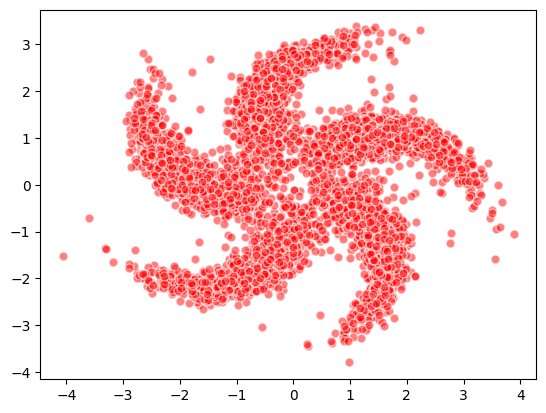

In [ ]:
num_samples = 10000

x = torch.randn((num_samples, 2), device=device) # xT ~ N(0, I)
x_store = []
with torch.no_grad():
    for i in range(n_T-1, -1, -1):
        t_is = torch.tensor([i]).to(device)
        t_is = t_is.repeat(num_samples, 1)

        eps = ddpm.nn_model(x, t_is)
        x = ddpm.oneover_sqrta[i, None] * (x - eps * ddpm.mab_over_sqrtmab[i]) + ddpm.sqrt_beta_t[i, None] * torch.randn_like(x)
        if i % 20 == 0 or i == n_T or i < 8:
            x_store.append(x.detach().cpu().numpy())

plt.clf()
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), alpha=0.5, color='red', edgecolor='white', s=40)
plt.show()
plt.close()